# SETUP

## SETUP

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!pip install -U "ray[tune]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 22.5 MB/s eta 0:00:00


In [3]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install pypots

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 66.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 40.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 4.1 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-qdiuhkbp
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-qdiuhkbp
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 0d013cf488a722d5a5b3bf657302fa7ca8b6d120
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=121

In [4]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 49.4 MB/s eta 0:00:00


In [5]:
!pip install pytorch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 6.7 MB/s eta 0:00:00


In [6]:
!mkdir -p datasets/knmi_station_data
!cp -r /content/drive/MyDrive/MAGISTERKA/datasets/knmi_station_data ./datasets/

## Imports

In [7]:
from collections import Counter
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pypots.utils.random import set_random_seed
from pypots.optim import Adam
from pypots.classification import Raindrop, BRITS, GRUD
# from pypots.nn.functional import calc_binary_classification_metrics, calc_mse, calc_rmse, calc_mae
# from pypots.nn.modules.loss import Criterion, MSE, MAE
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_forecasting.data.timeseries import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.models import Baseline, TemporalFusionTransformer
from pytorch_forecasting.metrics import MAE, RMSE, MASE

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
from torchmetrics import Metric
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from typing import Any, TypeVar
from collections import namedtuple


from ray.tune.schedulers import ASHAScheduler
import os
import tempfile
import json

import ray
from ray import tune

2025-06-09 21:44:06 [WARNING]: ‼️ PyPOTS Ecosystem configuration file does not exist.
2025-06-09 21:44:06 [INFO]: Wrote new configs to config.ini successfully.
2025-06-09 21:44:06 [INFO]: 💫 Initialized PyPOTS Ecosystem configuration file /root/.pypots/config.ini successfully.



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



In [8]:
BASE_PATH = Path("/content")
DRIVE_PATH = Path("/content/drive/MyDrive/MAGISTERKA")
SAVE_DIR = DRIVE_PATH / "lightning_logs/runs/forecast"

# Prepare df

In [37]:
stations = '215', '249', '323', '377'
# stations = '323',
test_station = '249'
stations = list(set(stations) - {test_station})

In [38]:
def _convert_vv_to_meters(vv_code):
    if pd.isna(vv_code):
        return np.nan

    vv_code = int(vv_code)

    if 0 <= vv_code <= 49:
        return vv_code * 100 + 50
    elif vv_code == 50:
        return 5500
    elif 51 <= vv_code <= 55:
        return np.nan
    elif 56 <= vv_code <= 79:
        return int((vv_code - 56 + 6.5) * 1000)
    elif vv_code == 80:
        return 32500
    elif 81 <= vv_code <= 88:
        return int(32500 + (vv_code - 81) * 5000)
    elif vv_code == 89:
        return 70000
    else:
        return np.nan

def _convert_vvm_to_simple(vv_m):
    if pd.isna(vv_m):
        return np.nan

    if vv_m < 500:
      return 0
    elif vv_m < 1000:
      return 1
    elif vv_m < 2000:
      return 2
    elif vv_m < 5000:
      return 3
    elif vv_m < 10000:
      return 4
    else:
      return 5

def _get_valid_vv_codes() -> list[int]:
    valid_codes = list(range(0, 51))
    valid_codes += list(range(56, 90))
    return valid_codes

def get_vv_one_hot_encoder() -> OneHotEncoder:
    valid_codes = _get_valid_vv_codes()
    categories = [np.array(valid_codes, dtype=np.int32)]
    encoder = OneHotEncoder(categories=categories, handle_unknown='ignore', dtype=np.float32, sparse_output=False)
    encoder.fit(categories[0].reshape(-1, 1))
    return encoder

def prepare_df(path: str) -> pd.DataFrame:
    try:
        header_line_index = -1
        column_names = []
        data_lines_start_index = -1

        # Find the header and its index more efficiently
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                if line.strip().startswith('# STN,YYYYMMDD,'):
                    header_line_index = i
                    column_names = [col.strip() for col in line.strip().lstrip('#').split(',')]
                    data_lines_start_index = header_line_index + 1
                    break

        if header_line_index == -1:
            raise ValueError("Header line not found.")

        # Use pandas.read_csv directly with skiprows and comment character
        # This avoids reading the whole file into a list first for data lines
        # and then joining them back.
        df = pd.read_csv(
            path,
            names=column_names,
            skiprows=data_lines_start_index,
            comment='#',  # Lines starting with '#' will be ignored as comments
            skipinitialspace=True,
            na_values=['       ', '     '] # Add other common missing value representations if needed
        )

        if df.empty:
            raise ValueError("No data found after the header or all data was commented out.")

        # Convert 'HH' to string and zfill, then create 'Timestamp'
        # It's crucial to handle potential NaN values in 'YYYYMMDD' or 'HH'
        # if they are not guaranteed to be present or valid in all rows.
        df['HH'] = df['HH'].astype(int) - 1
        df['HH'] = df['HH'].astype(str).str.zfill(2)
        df['Timestamp'] = pd.to_datetime(df['YYYYMMDD'].astype(str) + df['HH'].astype(str), format="%Y%m%d%H", errors='coerce')

        df.set_index('Timestamp', inplace=True)

        # Columns to drop
        cols_to_drop = ['YYYYMMDD', 'HH']
        df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

        # Convert remaining columns to numeric, efficiently
        # Identify numeric columns once and convert
        # Exclude already processed or known non-numeric columns if necessary
        for col in df.columns:
            # This check is slightly redundant if YYYYMMDD and HH are already dropped,
            # but good for safety if they weren't or if other non-numeric columns exist.
            if df[col].dtype == 'object': # Only attempt conversion if the column is of object type
                try:
                    df[col] = pd.to_numeric(df[col], downcast='signed')
                except ValueError:
                    # Handle or log cases where a column expected to be numeric isn't
                    # For now, we'll coerce, which turns unparseable into NaT/NaN
                    df[col] = pd.to_numeric(df[col], errors='coerce', downcast='signed')
        df['VV_m'] = df['VV'].apply(_convert_vv_to_meters)
        df['VV_s'] = df['VV_m'].apply(_convert_vvm_to_simple)

        return df

    except FileNotFoundError:
        print(f"Error: The file '{path}' was not found.")
        raise
    except ValueError as ve:
        print(f"ValueError: {ve}")
        raise
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        raise

In [39]:
dfs = []
for station in stations:
    df = prepare_df(f"./datasets/knmi_station_data/{station}.txt")
    df = df.set_index('STN', append=True)
    # Check whether VV column has any noy nulls
    nulls = df['VV'].isna().sum()
    dfs.append(df)

train_df = pd.concat(dfs)
train_df = df.reset_index()
train_df.head()

,Timestamp,STN,DD,FH,FF,FX,T,T10N,TD,SQ,...,U,WW,IX,M,R,S,O,Y,VV_m,VV_s
0,2015-01-01 00:00:00,215,210.0,50.0,50.0,70.0,27,NaN,8,0,...,87,10.0,7,0.0,0.0,0.0,0.0,0.0,4250.0,3.0
1,2015-01-01 01:00:00,215,220.0,50.0,50.0,70.0,26,NaN,4,0,...,85,10.0,7,0.0,0.0,0.0,0.0,0.0,7500.0,4.0
2,2015-01-01 02:00:00,215,200.0,50.0,40.0,80.0,23,NaN,2,0,...,86,NaN,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0
3,2015-01-01 03:00:00,215,210.0,40.0,40.0,70.0,21,NaN,1,0,...,87,NaN,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0
4,2015-01-01 04:00:00,215,190.0,50.0,50.0,80.0,19,NaN,2,0,...,88,NaN,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0


In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37248 entries, 0 to 37247
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  37248 non-null  datetime64[ns]
 1   STN        37248 non-null  int64         
 2   DD         37219 non-null  float64       
 3   FH         37219 non-null  float64       
 4   FF         37219 non-null  float64       
 5   FX         37219 non-null  float64       
 6   T          37248 non-null  int64         
 7   T10N       6208 non-null   float64       
 8   TD         37248 non-null  int64         
 9   SQ         37248 non-null  int64         
 10  Q          37248 non-null  int64         
 11  DR         37248 non-null  int64         
 12  RH         37248 non-null  int64         
 13  P          37233 non-null  float64       
 14  VV         37049 non-null  float64       
 15  N          37094 non-null  float64       
 16  U          37248 non-null  int64        

In [41]:
dfs = []
for station in [test_station]:
    df = prepare_df(f"./datasets/knmi_station_data/{station}.txt")
    df = df.set_index('STN', append=True)
    # Check whether VV column has any noy nulls
    nulls = df['VV'].isna().sum()
    dfs.append(df)

test_df = pd.concat(dfs)
test_df = df.reset_index()
test_df.head()

,Timestamp,STN,DD,FH,FF,FX,T,T10N,TD,SQ,...,U,WW,IX,M,R,S,O,Y,VV_m,VV_s
0,1999-03-16 00:00:00,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-03-16 01:00:00,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-03-16 02:00:00,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1999-03-16 03:00:00,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999-03-16 04:00:00,249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
SEQUENCE_LENGTH = 12
STEP_SIZE = 1
TARGET_COLUMN = 'VV_m'
NUMERICAL_COLS = [
    "FH", "FF", "FX", "T", "T10N", "TD", "SQ", "Q", "DR", "RH", "P", "U",
    # "DD"
]
CATEGORICAL_COLS = {
    # "WW", "IX", "VV"
}

vv_encoder = get_vv_one_hot_encoder()


# Pytorch forecasting dataset

In [43]:
def prepare_forecasting_df(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df = df[df[TARGET_COLUMN].notna()]

  prepared_dfs = []
  for station in df['STN'].unique():
    station_df = df[df['STN'] == station]
    station_df = station_df.sort_values('Timestamp').reset_index(drop=True)
    valid_times = station_df['Timestamp'].sort_values().reset_index(drop=True)
    time_diffs = valid_times.diff().fillna(pd.Timedelta(seconds=0))
    group = (time_diffs > pd.Timedelta(hours=1)).cumsum()
    station_df['TimeGroup'] = group
    station_df['TimeIdx'] = station_df.groupby('TimeGroup').cumcount()
    prepared_dfs.append(station_df)
  return pd.concat(prepared_dfs, axis=0).fillna(-1)

In [44]:
train_df_v2 = prepare_forecasting_df(train_df)
test_df_v2 = prepare_forecasting_df(test_df)

In [45]:
train_df_v2.head()

,Timestamp,STN,DD,FH,FF,FX,T,T10N,TD,SQ,...,IX,M,R,S,O,Y,VV_m,VV_s,TimeGroup,TimeIdx
0,2015-01-01 00:00:00,215,210.0,50.0,50.0,70.0,27,-1.0,8,0,...,7,0.0,0.0,0.0,0.0,0.0,4250.0,3.0,0,0
1,2015-01-01 01:00:00,215,220.0,50.0,50.0,70.0,26,-1.0,4,0,...,7,0.0,0.0,0.0,0.0,0.0,7500.0,4.0,0,1
2,2015-01-01 02:00:00,215,200.0,50.0,40.0,80.0,23,-1.0,2,0,...,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0,0,2
3,2015-01-01 03:00:00,215,210.0,40.0,40.0,70.0,21,-1.0,1,0,...,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0,0,3
4,2015-01-01 04:00:00,215,190.0,50.0,50.0,80.0,19,-1.0,2,0,...,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0,0,4


In [46]:
TRAIN_CUTOFF = pd.to_datetime('2021-01-01')
train_dataset = TimeSeriesDataSet(
    data=train_df_v2[train_df_v2['Timestamp'] < TRAIN_CUTOFF],
    time_idx='TimeIdx',
    target=TARGET_COLUMN,
    group_ids=['STN', 'TimeGroup'],
    min_encoder_length=8,
    max_encoder_length=8,
    min_prediction_length=1,
    max_prediction_length=1,
    time_varying_known_reals=NUMERICAL_COLS,
    add_relative_time_idx=False,
    categorical_encoders={
        'TimeGroup': NaNLabelEncoder(add_nan=True, warn=False),
        'STN': NaNLabelEncoder(add_nan=True, warn=False),
    }
)
validation_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_df_v2[train_df_v2['Timestamp'] >= TRAIN_CUTOFF],
    stop_randomization=True,
)
train_dataset

TimeSeriesDataSet[length=20110](
	time_idx='TimeIdx',
	target='VV_m',
	group_ids=['STN', 'TimeGroup'],
	weight=None,
	max_encoder_length=8,
	min_encoder_length=8,
	min_prediction_idx=0,
	min_prediction_length=1,
	max_prediction_length=1,
	static_categoricals=None,
	static_reals=None,
	time_varying_known_categoricals=None,
	time_varying_known_reals=['FH', 'FF', 'FX', 'T', 'T10N', 'TD', 'SQ', 'Q', 'DR', 'RH', 'P', 'U'],
	time_varying_unknown_categoricals=None,
	time_varying_unknown_reals=None,
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags=None,
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=None,
	center=True,
	scale_by_group=False,
	transformation='relu',
	method_kwargs={}
),
	categorical_encoders={'TimeGroup': NaNLabelEncoder(add_nan=True, warn=False), 'STN': NaNLabelEncoder(add_nan=True, warn=False), '__group_id__STN': NaNLabelEncoder(add_nan

In [47]:
target = train_df_v2.loc[train_dataset.index.index, TARGET_COLUMN].to_numpy()
# probabilities = np.ones_like(target)
# probabilities[target < 5000] = 3
# probabilities[target < 3000] = 5
# probabilities[target < 1000] = 10

train_dl = train_dataset.to_dataloader(
  batch_size=64,
  # sampler=WeightedRandomSampler(weights=probabilities, num_samples=len(probabilities), replacement=True),
  shuffle=False,
  num_workers=7
)

In [48]:
# target = train_df_v2.loc[validation_dataset.index.index, "VV_m"].to_numpy()
# probabilities = np.ones_like(target)
# probabilities[target < 5000] = 3
# probabilities[target < 3000] = 5
# probabilities[target < 1000] = 10

validation_dl = validation_dataset.to_dataloader(
  batch_size=64 * 10,
  # sampler=WeightedRandomSampler(weights=probabilities, num_samples=len(probabilities), replacement=True),
  shuffle=False,
  num_workers=7,
  drop_last=True
)

In [49]:
test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_df_v2,
    stop_randomization=True,
)

test_dl = test_dataset.to_dataloader(
  batch_size=64 * 10,
  shuffle=False,
  num_workers=7,
  drop_last=True
)

# Pypots dataset

In [50]:
train_df_v2 = prepare_forecasting_df(train_df)
test_df_v2 = prepare_forecasting_df(test_df)

train_df_v2.head()

,Timestamp,STN,DD,FH,FF,FX,T,T10N,TD,SQ,...,IX,M,R,S,O,Y,VV_m,VV_s,TimeGroup,TimeIdx
0,2015-01-01 00:00:00,215,210.0,50.0,50.0,70.0,27,-1.0,8,0,...,7,0.0,0.0,0.0,0.0,0.0,4250.0,3.0,0,0
1,2015-01-01 01:00:00,215,220.0,50.0,50.0,70.0,26,-1.0,4,0,...,7,0.0,0.0,0.0,0.0,0.0,7500.0,4.0,0,1
2,2015-01-01 02:00:00,215,200.0,50.0,40.0,80.0,23,-1.0,2,0,...,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0,0,2
3,2015-01-01 03:00:00,215,210.0,40.0,40.0,70.0,21,-1.0,1,0,...,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0,0,3
4,2015-01-01 04:00:00,215,190.0,50.0,50.0,80.0,19,-1.0,2,0,...,5,0.0,0.0,0.0,0.0,0.0,10500.0,5.0,0,4


In [51]:
def df_to_pypots(df: pd.DataFrame, prev_values: int=8, cols: list[str]=NUMERICAL_COLS, target_col: str = 'VV_s'):
  df = df.copy()
  X = []
  y = []
  for _, group in df.groupby(['TimeGroup', 'STN']):
    if len(group) < prev_values:
      continue
    # Sliding window over group and add to X, y
    for i in range(len(group) - prev_values):
      X.append(group.iloc[i:i+prev_values][cols].values)
      y.append(group.iloc[i+prev_values][target_col])
  X = np.array(X)
  y = np.array(y)
  print(X.shape, y.shape)
  return X, y

X_train, y_train = df_to_pypots(
    train_df_v2[train_df_v2['Timestamp'] < TRAIN_CUTOFF],
    prev_values=8,
    target_col=TARGET_COLUMN,
    cols=NUMERICAL_COLS + ['VV_m', 'VV'],
)

X_val, y_val = df_to_pypots(
    train_df_v2[train_df_v2['Timestamp'] >= TRAIN_CUTOFF],
    prev_values=8,
    target_col=TARGET_COLUMN,
    cols=NUMERICAL_COLS + ['VV_m', 'VV'],
)

X_test, y_test = df_to_pypots(
    test_df_v2,
    prev_values=8,
    target_col=TARGET_COLUMN,
    cols=NUMERICAL_COLS + ['VV_m', 'VV'],
)

(20110, 8, 14) (20110,)
(16819, 8, 14) (16819,)
(89253, 8, 14) (89253,)


In [52]:
def balance_dataset(X, y, up_to: int=2000):
  Xs = []
  ys = []
  for v, c in zip(*np.unique(y, return_counts=True)):
    if c < up_to:
      Xs.append(X[y == v])
      ys.append(y[y == v])
    else:
      # shuffle
      indexes = np.random.choice(c, up_to, replace=False)
      Xs.append(X[y == v][indexes])
      ys.append(y[y == v][indexes])
  return np.concatenate(Xs), np.concatenate(ys)

In [53]:
np.unique(y_train, return_counts=True)

(array([   50.,   150.,   250.,   350.,   450.,   550.,   650.,   750.,
          850.,   950.,  1050.,  1150.,  1250.,  1350.,  1450.,  1550.,
         1650.,  1750.,  1850.,  1950.,  2050.,  2150.,  2250.,  2350.,
         2450.,  2550.,  2650.,  2750.,  2850.,  2950.,  3050.,  3150.,
         3250.,  3350.,  3450.,  3550.,  3650.,  3750.,  3850.,  3950.,
         4050.,  4150.,  4250.,  4350.,  4450.,  4550.,  4650.,  4750.,
         4850.,  4950.,  5500.,  6500.,  7500.,  8500.,  9500., 10500.,
        11500., 12500., 13500., 14500., 15500., 16500., 17500., 18500.,
        19500., 20500., 21500., 22500., 23500., 24500., 25500., 26500.,
        27500., 28500., 29500., 32500., 37500., 42500.]),
 array([  37,  195,  129,   80,   44,   40,   28,   31,   34,   23,   22,
          33,   21,   29,   30,   26,   41,   31,   32,   34,   35,   44,
          38,   42,   55,   50,   49,   47,   55,   47,   50,   48,   52,
          56,   58,   59,   56,   41,   50,   48,   46,   45,   35,   50

In [54]:
np.unique(y_val, return_counts=True)

(array([   50.,   150.,   250.,   350.,   450.,   550.,   650.,   750.,
          850.,   950.,  1050.,  1150.,  1250.,  1350.,  1450.,  1550.,
         1650.,  1750.,  1850.,  1950.,  2050.,  2150.,  2250.,  2350.,
         2450.,  2550.,  2650.,  2750.,  2850.,  2950.,  3050.,  3150.,
         3250.,  3350.,  3450.,  3550.,  3650.,  3750.,  3850.,  3950.,
         4050.,  4150.,  4250.,  4350.,  4450.,  4550.,  4650.,  4750.,
         4850.,  4950.,  5500.,  6500.,  7500.,  8500.,  9500., 10500.,
        11500., 12500., 13500., 14500., 15500., 16500., 17500., 18500.,
        19500., 20500., 21500., 22500., 23500., 24500., 25500., 26500.,
        27500., 28500., 29500., 32500., 37500., 42500.]),
 array([  70,  213,  134,   83,   44,   24,   26,   28,   13,   16,   16,
          23,   31,   23,   18,   24,   18,   26,   27,   31,   29,   31,
          35,   30,   41,   23,   15,   25,   37,   40,   44,   31,   25,
          28,   36,   34,   36,   34,   31,   32,   29,   34,   39,   30

In [55]:
np.unique(y_test, return_counts=True)

(array([   50.,   150.,   250.,   350.,   450.,   550.,   650.,   750.,
          850.,   950.,  1050.,  1150.,  1250.,  1350.,  1450.,  1550.,
         1650.,  1750.,  1850.,  1950.,  2050.,  2150.,  2250.,  2350.,
         2450.,  2550.,  2650.,  2750.,  2850.,  2950.,  3050.,  3150.,
         3250.,  3350.,  3450.,  3550.,  3650.,  3750.,  3850.,  3950.,
         4050.,  4150.,  4250.,  4350.,  4450.,  4550.,  4650.,  4750.,
         4850.,  4950.,  5500.,  6500.,  7500.,  8500.,  9500., 10500.,
        11500., 12500., 13500., 14500., 15500., 16500., 17500., 18500.,
        19500., 20500., 21500., 22500., 23500., 24500., 25500., 26500.,
        27500., 28500., 29500., 32500., 37500., 42500., 47500.]),
 array([ 442,  806,  480,  300,  222,  176,  159,  158,  180,  189,  184,
         219,  197,  224,  220,  234,  242,  232,  238,  279,  289,  248,
         278,  282,  267,  288,  279,  296,  269,  293,  276,  284,  318,
         277,  274,  312,  299,  300,  313,  324,  283,  274,  2

In [56]:
X_train_bal, y_train_bal = balance_dataset(X_train, y_train, up_to=250)
X_val_bal, y_val_bal = balance_dataset(X_val, y_val, up_to=50)
X_test_bal, y_test_bal = balance_dataset(X_test, y_test, up_to=100)

In [57]:
np.unique(y_train_bal, return_counts=True), len(y_train_bal)

((array([   50.,   150.,   250.,   350.,   450.,   550.,   650.,   750.,
           850.,   950.,  1050.,  1150.,  1250.,  1350.,  1450.,  1550.,
          1650.,  1750.,  1850.,  1950.,  2050.,  2150.,  2250.,  2350.,
          2450.,  2550.,  2650.,  2750.,  2850.,  2950.,  3050.,  3150.,
          3250.,  3350.,  3450.,  3550.,  3650.,  3750.,  3850.,  3950.,
          4050.,  4150.,  4250.,  4350.,  4450.,  4550.,  4650.,  4750.,
          4850.,  4950.,  5500.,  6500.,  7500.,  8500.,  9500., 10500.,
         11500., 12500., 13500., 14500., 15500., 16500., 17500., 18500.,
         19500., 20500., 21500., 22500., 23500., 24500., 25500., 26500.,
         27500., 28500., 29500., 32500., 37500., 42500.]),
  array([ 37, 195, 129,  80,  44,  40,  28,  31,  34,  23,  22,  33,  21,
          29,  30,  26,  41,  31,  32,  34,  35,  44,  38,  42,  55,  50,
          49,  47,  55,  47,  50,  48,  52,  56,  58,  59,  56,  41,  50,
          48,  46,  45,  35,  50,  42,  51,  45,  51,  46,  30

In [58]:
np.unique(y_val_bal, return_counts=True)

(array([   50.,   150.,   250.,   350.,   450.,   550.,   650.,   750.,
          850.,   950.,  1050.,  1150.,  1250.,  1350.,  1450.,  1550.,
         1650.,  1750.,  1850.,  1950.,  2050.,  2150.,  2250.,  2350.,
         2450.,  2550.,  2650.,  2750.,  2850.,  2950.,  3050.,  3150.,
         3250.,  3350.,  3450.,  3550.,  3650.,  3750.,  3850.,  3950.,
         4050.,  4150.,  4250.,  4350.,  4450.,  4550.,  4650.,  4750.,
         4850.,  4950.,  5500.,  6500.,  7500.,  8500.,  9500., 10500.,
        11500., 12500., 13500., 14500., 15500., 16500., 17500., 18500.,
        19500., 20500., 21500., 22500., 23500., 24500., 25500., 26500.,
        27500., 28500., 29500., 32500., 37500., 42500.]),
 array([50, 50, 50, 50, 44, 24, 26, 28, 13, 16, 16, 23, 31, 23, 18, 24, 18,
        26, 27, 31, 29, 31, 35, 30, 41, 23, 15, 25, 37, 40, 44, 31, 25, 28,
        36, 34, 36, 34, 31, 32, 29, 34, 39, 30, 27, 34, 24, 41, 28, 40, 50,
        50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50

In [59]:
# Shuffle datasets
indexes = np.random.permutation(len(X_train_bal))
X_train_bal = X_train_bal[indexes]
y_train_bal = y_train_bal[indexes]

indexes = np.random.permutation(len(X_val_bal))
X_val_bal = X_val_bal[indexes]
y_val_bal = y_val_bal[indexes]

indexes = np.random.permutation(len(X_test_bal))
X_test_bal = X_test_bal[indexes]
y_test_bal = y_test_bal[indexes]



# Plots

In [28]:
def prepare_predictions(model, dataloader):
  ys_pred = []
  ys_true = []
  for x, y in iter(dataloader):
    y_pred = model.forward(x)
    ys_pred.append(torch.squeeze(y_pred.prediction.detach()))
    ys_true.append(torch.squeeze(y[0]))

  ys_pred = torch.cat(ys_pred)
  ys_true = torch.cat(ys_true)

  # For each unique value in ys_true calculate mean prediction and std of prediction
  ys_true_unique = ys_true.unique()
  ys_pred_mean = []
  ys_pred_std = []
  ys_pred_all = []

  for unique_value in ys_true_unique:
    mask = ys_true == unique_value
    ys_pred_mean.append(ys_pred[mask].mean())
    ys_pred_std.append(ys_pred[mask].std())
    ys_pred_all.append(ys_pred[mask])

  ys_pred_mean = torch.tensor(ys_pred_mean)
  ys_pred_std = torch.tensor(ys_pred_std)

  return ys_pred_all, ys_true_unique, ys_pred_mean, ys_pred_std

def boxplot_predictions(ys_pred_all, ys_true_unique):
  # On X ys_true, sorted from smallest to biggest
  # On Y boxplot of preds for this next x's
  max_pred = ys_pred_all[0].max()
  for i in range(1, len(ys_pred_all)):
    max_pred = max(max_pred, ys_pred_all[i].max())
  fig, ax = plt.subplots(figsize=(16, 10))

  data = []
  for preds, true in zip(ys_pred_all, ys_true_unique):
    for pred in preds:
      data.append((true.item(), pred.item()))
  df = pd.DataFrame(data, columns=['true', 'pred'])
  sns.boxplot(x='true', y='pred', data=df, ax=ax)
  # Rotate xticks
  plt.xticks(rotation=90)

  # plot expected value on bars
  for i, true in enumerate(ys_true_unique):
    y_val = true.item()

    x_start = i - 0.2
    x_end = i + 0.2
    start_ax = ax.transData.transform((x_start, 0))[0]
    end_ax = ax.transData.transform((x_end, 0))[0]
    inv = ax.transAxes.inverted()
    xmin_axes = inv.transform((start_ax, 0))[0]
    xmax_axes = inv.transform((end_ax, 0))[0]

    ax.axhline(y=y_val, xmin=xmin_axes, xmax=xmax_axes, color='red', linewidth=2)
  return ax

def boxplot_predictions_zoomed(ys_pred_all, ys_true_unique, max_y=5000):
  ys_pred_all_ = []
  ys_preds_unique_ = []
  for preds, true in zip(ys_pred_all, ys_true_unique):
    if true <= max_y:
      ys_pred_all_.append(preds)
      ys_preds_unique_.append(true)
  ys_preds_unique_ = torch.tensor(ys_preds_unique_)
  max_pred = ys_pred_all_[0].max()
  for i in range(1, len(ys_pred_all_)):
    max_pred = max(max_pred, ys_pred_all_[i].max())

  data = []
  for preds, true in zip(ys_pred_all_, ys_preds_unique_):
    for pred in preds:
      data.append((true.item(), pred.item()))
  df = pd.DataFrame(data, columns=['true', 'pred'])
  fig, ax = plt.subplots(figsize=(16, 10))
  sns.boxplot(x='true', y='pred', data=df, ax=ax)
  # Rotate xticks
  plt.xticks(rotation=90)


  # plot expected value on bars
  for i, true in enumerate(ys_true_unique):
    y_val = true.item()
    if y_val > max_y:
      continue

    x_start = i - 0.2
    x_end = i + 0.2
    start_ax = ax.transData.transform((x_start, 0))[0]
    end_ax = ax.transData.transform((x_end, 0))[0]
    inv = ax.transAxes.inverted()
    xmin_axes = inv.transform((start_ax, 0))[0]
    xmax_axes = inv.transform((end_ax, 0))[0]

    ax.axhline(y=y_val, xmin=xmin_axes, xmax=xmax_axes, color='red', linewidth=2)

  return ax


In [29]:
def calculate_dm_metrics(ys_pred_all, ys_true_unique, splits: list[int] = [500, 1000, 2000, 5000, 10000]):
  # splits is <min, max> so for this array it will be for 0-500, 500-1000, 1000-2000, 2000-5000, 5000-10000, 10000-MAX
  results = {}
  min_value = ys_true_unique.min().item()
  max_value = ys_true_unique.max().item()
  for min_y, max_y in zip([min_value] + splits, splits + [max_value]):
    mask = (ys_true_unique >= min_y) & (ys_true_unique < max_y)
    ys_true_filtered = ys_true_unique[mask]
    ys_pred_filtered = []
    for i, v in enumerate(mask):
      if v:
        ys_pred_filtered.append(ys_pred_all[i])
    ys_pred = []
    ys_true = []
    for preds, true in zip(ys_pred_filtered, ys_true_filtered):
      for pred in preds:
        ys_pred.append(pred.item())
        ys_true.append(true.item())
    ys_pred = torch.tensor(ys_pred).unsqueeze(-1)
    ys_true = torch.tensor(ys_true).unsqueeze(-1)
    mae = MAE()(ys_pred, ys_true)
    rmse = RMSE()(ys_pred, ys_true)
    results[f"{int(min_y)}-{int(max_y)}"] = {
        "mae": mae.item(),
        "rmse": rmse.item(),
    }
  return results

def average_metrics(metrics: list[dict[dict[str, float]]]):
  results = {}
  for metrics_dict in metrics:
    for split, metrics in metrics_dict.items():
      if split not in results:
        results[split] = {}
      for metric, value in metrics.items():
        if metric not in results[split]:
          results[split][metric] = []
        results[split][metric].append(value)

  for split, metrics_dict in results.items():
    for metric, values in metrics_dict.items():
      mean = np.mean(values)
      std = np.std(values)
      results[split][metric] = {
          "mean": float(mean),
          "std": float(std),
      }
  return results

# Custom loss

In [30]:
class VisibilityLoss(Metric):
    def __init__(self, alpha=3.0, beta=1.5, gamma=1.0, dist_sync_on_step=False):
        """
        alpha: weight for visibility < 1000m
        beta: weight for visibility between 1000–5000m
        gamma: weight for visibility > 5000m
        """
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.add_state("squared_errors_sum", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("weights_sum", default=torch.tensor(0.0), dist_reduce_fx="sum")


    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        # Ensure tensors are on the same device if necessary
        y_pred = y_pred.to(self.squared_errors_sum.device)
        y_true = y_true.to(self.squared_errors_sum.device)

        log_pred = torch.log1p(y_pred)
        log_true = torch.log1p(y_true)
        error = (log_pred - log_true) ** 2

        weights = torch.where(
            y_true < 1000, self.alpha,
            torch.where(y_true < 5000, self.beta, self.gamma)
        )

        self.squared_errors_sum += (weights * error).sum()
        self.weights_sum += weights.sum()

    def compute(self):
        # Calculate the weighted mean squared error
        return self.squared_errors_sum / self.weights_sum if self.weights_sum > 0 else torch.tensor(0.0)


class Log1PMSE(Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)

        # Define state variables for accumulating results
        self.add_state("sum_sq_err", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        # Ensure tensors are on the same device if necessary
        y_pred = y_pred.to(self.sum_sq_err.device)
        y_true = y_true.to(self.sum_sq_err.device)

        log_pred = torch.log1p(y_pred)
        log_true = torch.log1p(y_true)

        self.sum_sq_err += F.mse_loss(log_pred, log_true, reduction='sum')
        self.total += y_true.numel()

    def compute(self):
        return self.sum_sq_err / self.total if self.total > 0 else torch.tensor(0.0)

# Model training


INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


Number of parameters in network: 13.7k


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.000457088189614875
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.000457088189614875
INFO: Restoring states from the checkpoint path at /content/.lr_find_3ab2f3ad-06b5-4329-bb37-b9077c480764.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_3ab2f3ad-06b5-4329-bb37-b9077c480764.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_3ab2f3ad-06b5-4329-bb37-b9077c480764.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_3ab2f3ad-06b5-4329-bb37-b9077c480764.ckpt


suggested learning rate: 0.000457088189614875


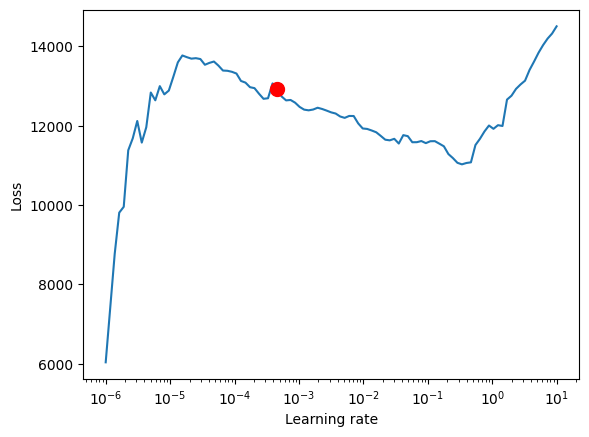

In [ ]:
trainer = L.Trainer(
    accelerator="cpu",
    gradient_clip_val=0.1
)

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=0.03,
    hidden_size=8,
    # Up to 4 recommended
    attention_head_size=1,
    # Recommended 0.1-0.3
    dropout=0.1,
    # Should be <= than hidden_size
    hidden_continuous_size=8,
    loss=RMSE(),
    # optimizer="ranger"
)

print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dl,
    val_dataloaders=validation_dl,
    max_lr=10,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# Deep models

# Temporal Fusion Transformer

In [ ]:
metrics = []
for i in range(2):
  trainer = L.Trainer(
    max_epochs=100,
    # logger=L.pytorch.loggers.TensorBoardLogger(
    #     save_dir=SAVE_DIR / 'tft',
    #     name=f"tft",
    #     version=f"1000{i:02}",
    # ),
    callbacks=[
        L.pytorch.callbacks.early_stopping.EarlyStopping(
            monitor="val_loss", mode="min", patience=5, verbose=False
        ),
        # L.pytorch.callbacks.ModelCheckpoint(
        #     monitor="val_loss",
        #     mode="max",
        #     dirpath=SAVE_DIR / 'tft',
        #     filename=f"tft",
        # ),
    ],
    log_every_n_steps=1,
    gradient_clip_val=0.1,
    # fast_dev_run=True
  )

  tft = TemporalFusionTransformer.from_dataset(
      train_dataset,
      learning_rate=0.03,
      hidden_size=8,
      # Up to 4 recommended
      attention_head_size=1,
      # Recommended 0.1-0.3
      dropout=0.1,
      # Should be <= than hidden_size
      hidden_continuous_size=8,
      loss=MASE(),
      # loss=Log1PMSE(),
      # learning_rate=0.01,
      # optimizer="ranger"
  )

  trainer.fit(tft, train_dataloaders=train_dl, val_dataloaders=validation_dl)

  ys_pred_all, ys_true_unique, ys_pred_mean, ys_pred_std = prepare_predictions(tft, validation_dl)
  metrics.append(calculate_dm_metrics(ys_pred_all, ys_true_unique))

average_metrics(metrics)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/lo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Not deep models

In [31]:
from sklearn.svm import SVC, LinearSVC, LinearSVR, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, XGBRegressor
from sklearn.base import ClassifierMixin, RegressorMixin
from typing import Any, TypeVar
from collections import namedtuple
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from time import time

import ray
from ray import tune


In [32]:
def calculate_metrics(y_pred, y_true, splits: list[int] = [500, 1000, 2000, 5000, 10000]):
  # splits is <min, max> so for this array it will be for 0-500, 500-1000, 1000-2000, 2000-5000, 5000-10000, 10000-MAX
  results = {}
  min_value = 0
  max_value = y_true.max().item()
  for min_y, max_y in zip([min_value] + splits, splits + [max_value]):
    mask = (y_true >= min_y) & (y_true < max_y)
    ys_true = y_true[mask]
    ys_pred = y_pred[mask]

    mae = mean_absolute_error(ys_true, ys_pred)
    mse = mean_squared_error(ys_true, ys_pred)
    # r2 = r2_score(ys_true, ys_pred)
    results[f"{int(min_y)}-{int(max_y)}"] = {
        "mae": mae,
        "mse": mse,
        # "r2": r2
    }
  return results

def average_metrics(metrics: list[dict[dict[str, float]]]):
  results = {}
  # metrics is list of:
  # {'50-500': {'mae': 752.0321044921875, 'rmse': 934.5390014648438},
  #  '500-1000': {'mae': 723.1170043945312, 'rmse': 1165.4361572265625},
  #  '1000-2000': {'mae': 1082.502197265625, 'rmse': 1697.314453125},
  #  '2000-5000': {'mae': 1743.2655029296875, 'rmse': 2340.599609375},
  #  '5000-10000': {'mae': 3225.502685546875, 'rmse': 3892.3681640625},
  #  '10000-47500': {'mae': 9657.6806640625, 'rmse': 10859.7509765625}}
  for metrics_dict in metrics:
    for split, metrics in metrics_dict.items():
      if split not in results:
        results[split] = {}
      for metric, value in metrics.items():
        if metric not in results[split]:
          results[split][metric] = []
        results[split][metric].append(value)

  for split, metrics_dict in results.items():
    for metric, values in metrics_dict.items():
      mean = np.mean(values)
      std = np.std(values)
      results[split][metric] = {
          "mean": float(mean),
          "std": float(std),
      }
  return results


In [33]:
_T = TypeVar('_T', bound=RegressorMixin)

def evaluate_classic_model(model: _T, X: Any, y: Any):
  y_pred = model.predict(X)
  mae = mean_absolute_error(y, y_pred)
  mse = mean_squared_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  return namedtuple('Metrics', ['mae', 'mse', 'r2'])(mae, mse, r2)

def _get_formatted_metric(values: list[float]):
  avg = sum(values) / len(values)
  std = (sum([(v - avg) ** 2 for v in values]) / len(values)) ** 0.5
  return f"{avg:.4f} ± {std:.4f}"


def run_classic_model(
        model_cls: _T,
        model_kwargs: dict[str, Any],
        X_train, y_train,
        # X_val, y_val,
        X_test, y_test,
        repeat: int = 5
):
  if X_train.ndim == 3:
      X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
  # if X_val.ndim == 3:
  #     X_val = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))
  if X_test.ndim == 3:
      X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

  metrics = []
  training_times = []
  for _ in range(repeat):
    model = model_cls(**model_kwargs)
    _start = time()
    model.fit(X_train, y_train)
    _end = time()
    training_times.append(_end - _start)
    # results = evaluate_classic_model(model, X_test, y_test)
    # final_res['mae'].append(results.mae)
    # final_res['mse'].append(results.mse)
    # final_res['r2'].append(results.r2)
    metrics.append(calculate_metrics(model.predict(X_test), y_test))

  final_res = average_metrics(metrics)

  # print(
  #   f"{model_cls}"
  #   f" & {_get_formatted_metric(final_res['mae'])}"
  #   f" & {_get_formatted_metric(final_res['mse'])}"
  #   f" & {_get_formatted_metric(final_res['r2'])}"
  #   f"\\\\"
  # )
  print(training_times)
  print(_get_formatted_metric(training_times))
  # print(json.dumps(final_res, indent=2))
  res_str = "Range & MAE & RMSE & R2 \\\\\n"
  for r, v in final_res.items():
    row_str = f"{r} & "
    for metric, values in v.items():
      row_str += f"{values['mean']:.4f} ± {values['std']:.4f} & "
    # print(row_str[:-2] + "\\\\")
    res_str += row_str[:-2] + "\\\\\n"
  print(res_str)



In [34]:
def train_classic_model(model_cls, model_kwargs, X, y):
  model = model_cls(**model_kwargs)
  if X.ndim == 3:
      X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
  model.fit(X, y)
  return model

def prepare_classic_predictions(model: _T, X, y):
  if X.ndim == 3:
      X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
  y_pred = model.predict(X)
  # group predictions by unique y
  unique_y = np.unique(y)
  y_pred_unique = []
  y_unique = []
  for unique in unique_y:
    mask = y == unique
    y_pred_unique.append(y_pred[mask])
    y_unique.append(unique)
  return {
      "y_true": y,
      "y_pred": y_pred,
      "y_pred_unique": y_pred_unique,
      "y_true_unique": y_unique,
  }

In [35]:
def train_model_tune(
    config,
    model_cls: _T,
    X_train, y_train,
    X_val, y_val
):
  if X_train.ndim == 3:
      X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
  if X_val.ndim == 3:
      X_val = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

  model = model_cls(**config)

  model.fit(X_train, y_train)
  val_metrics = evaluate_classic_model(model, X_val, y_val)

  tune.report(
      {
        "mae": val_metrics.mae,
        "mse": val_metrics.mse,
        "r2": val_metrics.r2,
      }
  )

## SVC

In [ ]:
tuner = tune.Tuner(
    tune.with_parameters(
        train_model_tune,
        model_cls=LinearSVR,
        X_train=X_train_bal,
        y_train=y_train_bal,
        X_val=X_val_bal,
        y_val=y_val_bal,
    ),
    param_space={
        "C": tune.grid_search([0.1, 0.8, 1, 1.2, 2.0, 10]),
    },
    tune_config=tune.TuneConfig(
        num_samples=1,
        metric="mae",
        mode="min"
    )
)

results = tuner.fit()
best_metrics = results.get_best_result().metrics
print(f"Best params: {results.get_best_result().config}")
for k, v in best_metrics.items():
  if isinstance(v, float):
    print(f"{k}: {v:.4f}")
  else:
    print(f"{k}: {v}")

+-------------------------------------------------------------------------+
| Configuration for experiment     train_model_tune_2025-06-09_15-06-01   |
+-------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                  |
| Scheduler                        FIFOScheduler                          |
| Number of trials                 6                                      |
+-------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_tune_2025-06-09_15-06-01
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-06-09_14-03-33_810244_3164/artifacts/2025-06-09_15-06-01/train_model_tune_2025-06-09_15-06-01/driver_artifacts`

Trial status: 6 PENDING
Current time: 2025-06-09 15:06:01. Total running time: 0s
Logical resource usage: 6.0/8 CPUs, 0/0 GPUs
+------------------------------------------------+


(train_model_tune pid=56465) /usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
(train_model_tune pid=56465)   warnings.warn(



Trial train_model_tune_41bb8_00002 completed after 1 iterations at 2025-06-09 15:06:18. Total running time: 16s
+-----------------------------------------------------------+
| Trial train_model_tune_41bb8_00002 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  13.3413 |
| time_total_s                                      13.3413 |
| training_iteration                                      1 |
| mae                                               3599.95 |
| mse                                           3.29681e+07 |
| r2                                                0.76116 |
+-----------------------------------------------------------+

Trial train_model_tune_41bb8_00000 completed after 1 iterations at 2025-06-09 15:06:19. Total running time: 17s
+-----------------------------------------------------------+
| Trial train_model_tune_41bb8

2025-06-09 15:06:19,720	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_tune_2025-06-09_15-06-01' in 0.0144s.



Trial train_model_tune_41bb8_00004 completed after 1 iterations at 2025-06-09 15:06:19. Total running time: 18s
+-----------------------------------------------------------+
| Trial train_model_tune_41bb8_00004 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  14.0827 |
| time_total_s                                      14.0827 |
| training_iteration                                      1 |
| mae                                               4056.15 |
| mse                                           3.71146e+07 |
| r2                                                0.73112 |
+-----------------------------------------------------------+

Trial status: 6 TERMINATED
Current time: 2025-06-09 15:06:19. Total running time: 18s
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Current best trial: 41bb8_00001 with mae=3412.0859265222957 and params={'

In [60]:
run_classic_model(
    LinearSVR,
    # results.get_best_result().config,
    {"C": 0.8},
    X_train=X_train_bal,
    y_train=y_train_bal,
    # X_val=X_val_bal,
    # y_val=y_val_bal,
    X_test=X_test_bal,
    y_test=y_test_bal,
)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[2.0176689624786377, 2.0851244926452637, 1.9722065925598145, 2.103456974029541, 2.3048806190490723]
2.0967 ± 0.1142
Range & MAE & RMSE & R2 \\
0-500 & 1768.9783 ± 596.9887 & 7840552.4221 ± 3483633.4142 \\
500-1000 & 1665.9123 ± 394.2351 & 8001454.4486 ± 1860703.1428 \\
1000-2000 & 1752.4688 ± 471.0380 & 8524909.4072 ± 1955895.3090 \\
2000-5000 & 2451.5827 ± 624.5615 & 13740252.3509 ± 3467644.1161 \\
5000-10000 & 3498.9626 ± 1057.8525 & 23861972.3881 ± 8717073.7208 \\
10000-47500 & 5529.0440 ± 2867.2874 & 55027905.6610 ± 49202444.7400 \\



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [61]:
run_classic_model(
    LinearSVR,
    # results.get_best_result().config,
    {"C": 0.8},
    X_train=X_train_bal,
    y_train=y_train_bal,
    # X_val=X_val_bal,
    # y_val=y_val_bal,
    X_test=X_val_bal,
    y_test=y_val_bal,
)

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[2.5255520343780518, 2.0345675945281982, 2.0510413646698, 2.148758888244629, 2.329360246658325]
2.2179 ± 0.1862
Range & MAE & RMSE & R2 \\
0-500 & 2192.3349 ± 740.7985 & 13111166.1963 ± 5153637.5832 \\
500-1000 & 3134.1273 ± 836.2765 & 26009642.3988 ± 9412026.2484 \\
1000-2000 & 2955.2117 ± 834.9899 & 32153421.7628 ± 10784190.0424 \\
2000-5000 & 2969.6577 ± 651.6426 & 23136698.1839 ± 8082216.7793 \\
5000-10000 & 3422.1617 ± 386.9956 & 25623209.4937 ± 7041658.1973 \\
10000-42500 & 4276.6127 ± 872.1293 & 31177359.7638 ± 9451263.5636 \\



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


(0.0, 10000.0)

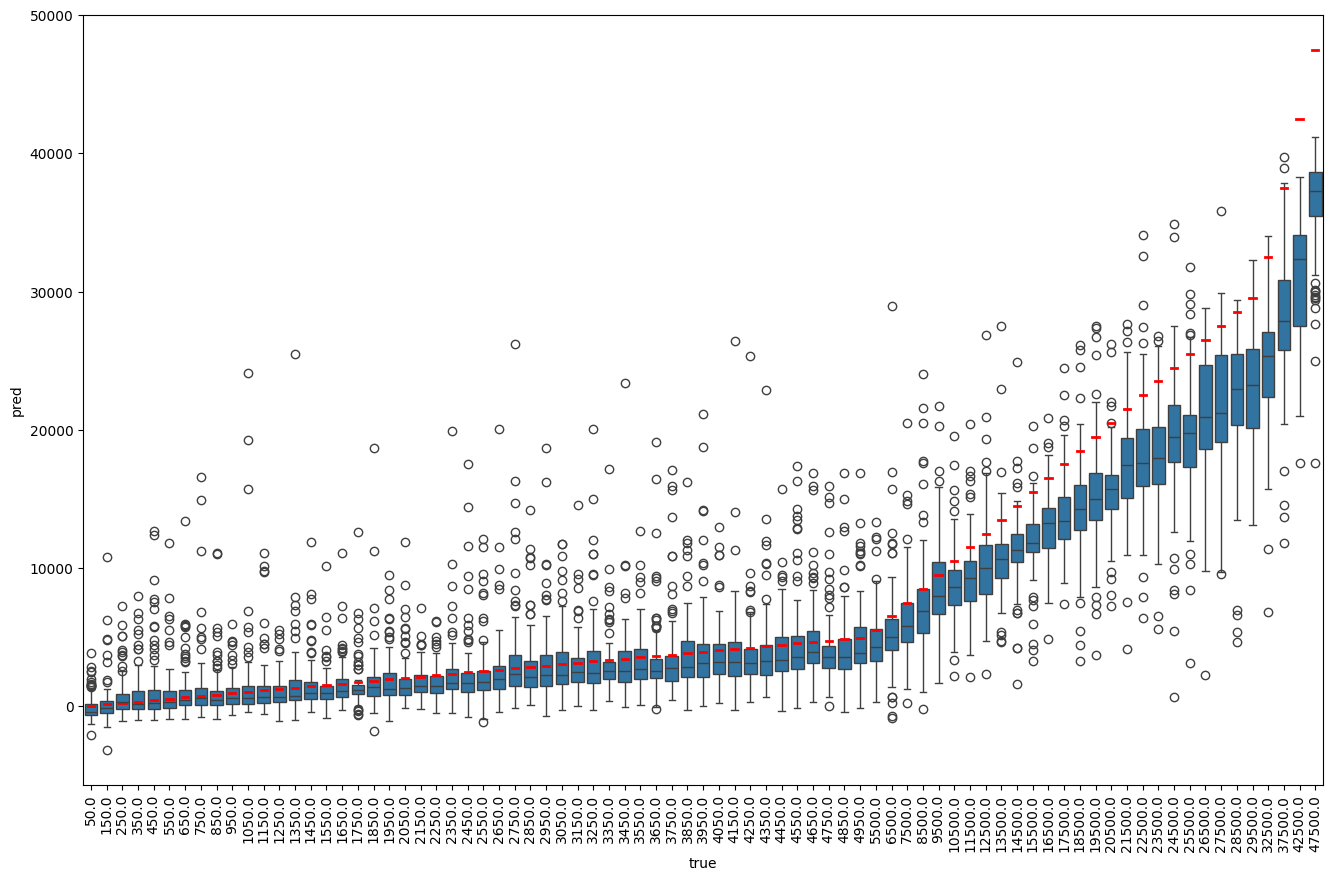

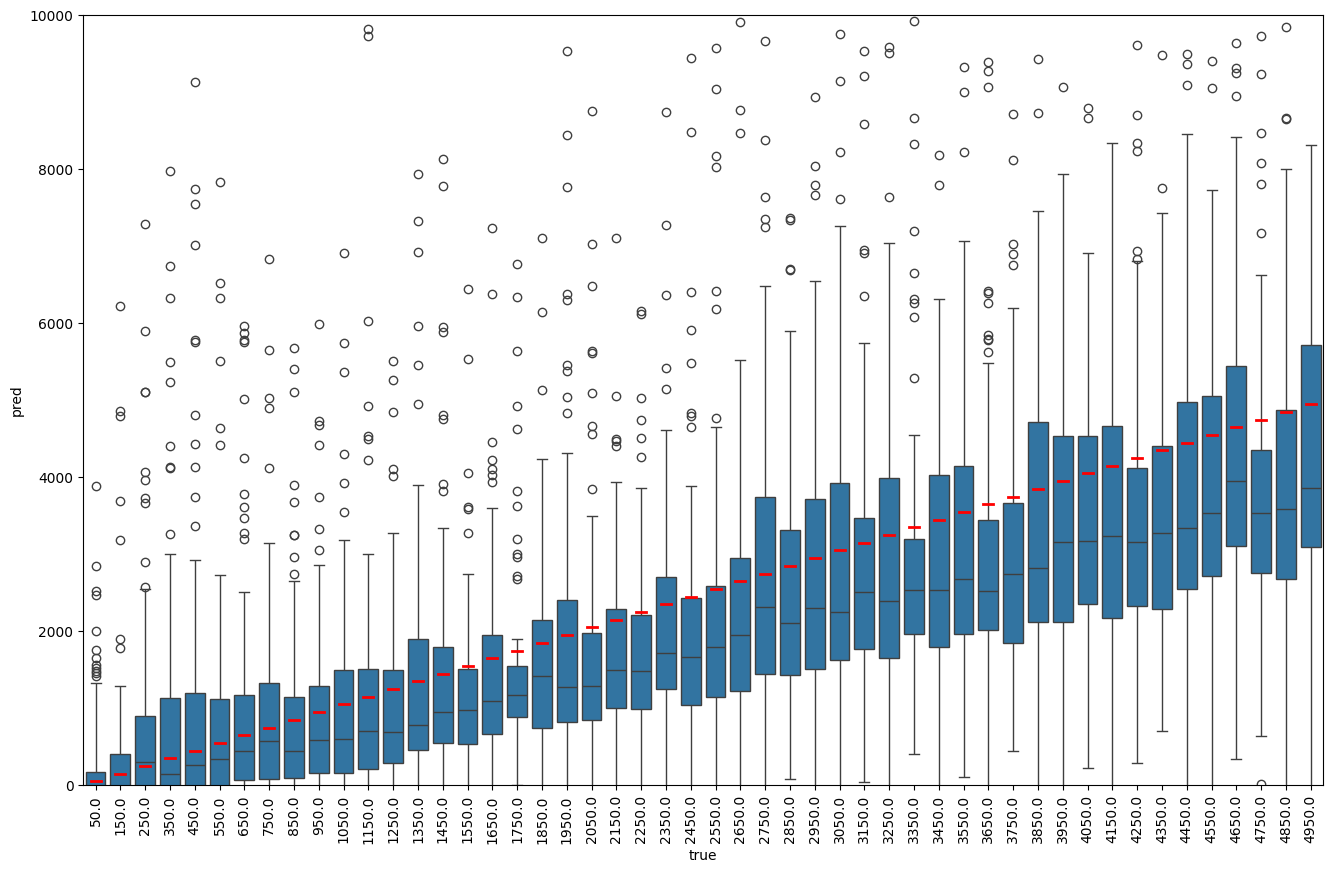

In [62]:
preds = prepare_classic_predictions(
    train_classic_model(
        LinearSVR,
        # results.get_best_result().config,
        {"C": 0.8},
        X_train_bal,
        y_train_bal,
    ),
    X_test_bal,
    y_test_bal,
)

boxplot_predictions(
    preds["y_pred_unique"], preds["y_true_unique"]
)
ax = boxplot_predictions_zoomed(
    preds["y_pred_unique"], preds["y_true_unique"]
)
ax.set_ylim(0, 10000)

## RFC

In [ ]:
tuner = tune.Tuner(
    tune.with_parameters(
        train_model_tune,
        model_cls=RandomForestRegressor,
        X_train=X_train_bal,
        y_train=y_train_bal,
        X_val=X_val_bal,
        y_val=y_val_bal,
    ),
    param_space={
        "n_estimators": tune.grid_search([10, 50, 100, 150]),
        "max_depth": tune.grid_search([1, 3, 5, 10, None]),
        "criterion": tune.grid_search(['squared_error', 'poisson']),
        "max_features": tune.grid_search(['sqrt', 'log2', 0.3, 0.5, None])
    },
    tune_config=tune.TuneConfig(
        num_samples=1,
        metric="mae",
        mode="min"
    )
)

results = tuner.fit()
best_metrics = results.get_best_result().metrics
print(f"Best params: {results.get_best_result().config}")
for k, v in best_metrics.items():
  if isinstance(v, float):
    print(f"{k}: {v:.4f}")
  else:
    print(f"{k}: {v}")

2025-06-09 14:03:36,408	INFO worker.py:1888 -- Started a local Ray instance.
2025-06-09 14:03:37,780	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.49854 |
| time_total_s                                      0.49854 |
| training_iteration                                      1 |
| mae                                               5149.17 |
| mse                                           5.53477e+07 |
| r2                                                0.59902 |
+-----------------------------------------------------------+

Trial train_model_tune_8a3a2_00002 completed after 1 iterations at 2025-06-09 14:03:45. Total running time: 7s
+-----------------------------------------------------------+
| Trial train_model_tune_8a3a2_00002 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_

2025-06-09 14:14:42,269	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_tune_2025-06-09_14-03-33' in 0.0464s.



Trial train_model_tune_8a3a2_00199 completed after 1 iterations at 2025-06-09 14:14:42. Total running time: 11min 4s
+-----------------------------------------------------------+
| Trial train_model_tune_8a3a2_00199 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  176.675 |
| time_total_s                                      176.675 |
| training_iteration                                      1 |
| mae                                               3129.69 |
| mse                                           2.86897e+07 |
| r2                                                0.79215 |
+-----------------------------------------------------------+

Trial status: 200 TERMINATED
Current time: 2025-06-09 14:14:42. Total running time: 11min 4s
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Current best trial: 8a3a2_00177 with mae=3009.846244889139 an

In [63]:
run_classic_model(
    RandomForestRegressor,
    # results.get_best_result().config,
    {'n_estimators': 150, 'max_depth': 10, 'criterion': 'poisson', 'max_features': 0.3},
    X_train=X_train_bal,
    y_train=y_train_bal,
    # X_val=X_val_bal,
    # y_val=y_val_bal,
    X_test=X_test_bal,
    y_test=y_test_bal,
)

[11.128553628921509, 11.09371566772461, 11.108069658279419, 11.159560918807983, 11.112972021102905]
11.1206 ± 0.0224
Range & MAE & RMSE & R2 \\
0-500 & 1876.0134 ± 130.7868 & 5607618.7421 ± 375475.4983 \\
500-1000 & 2020.0630 ± 108.1096 & 7037546.6326 ± 403680.8274 \\
1000-2000 & 1726.5375 ± 80.0992 & 6823524.2569 ± 231806.1931 \\
2000-5000 & 1804.5269 ± 29.6956 & 9224854.0773 ± 159600.6914 \\
5000-10000 & 2157.3919 ± 14.8162 & 11673658.7260 ± 147260.5343 \\
10000-47500 & 4561.1390 ± 56.9191 & 43028410.3369 ± 1317480.1622 \\



In [64]:
run_classic_model(
    RandomForestRegressor,
    # results.get_best_result().config,
    {'n_estimators': 150, 'max_depth': 10, 'criterion': 'poisson', 'max_features': 0.3},
    X_train=X_train_bal,
    y_train=y_train_bal,
    # X_val=X_val_bal,
    # y_val=y_val_bal,
    X_test=X_val_bal,
    y_test=y_val_bal,
)

[11.11551833152771, 11.075430631637573, 11.116389036178589, 11.07621955871582, 11.107817649841309]
11.0983 ± 0.0186
Range & MAE & RMSE & R2 \\
0-500 & 1815.0291 ± 16.5328 & 8275506.5554 ± 72191.9751 \\
500-1000 & 2721.6627 ± 13.5246 & 19716951.4106 ± 269026.6513 \\
1000-2000 & 2499.0812 ± 9.4476 & 22677687.8132 ± 414658.1136 \\
2000-5000 & 2564.8100 ± 8.1884 & 18769000.9937 ± 114843.7709 \\
5000-10000 & 2916.4828 ± 13.0591 & 20337908.1053 ± 236332.3030 \\
10000-42500 & 3283.1240 ± 11.6538 & 20387385.3770 ± 150696.5276 \\



(0.0, 10000.0)

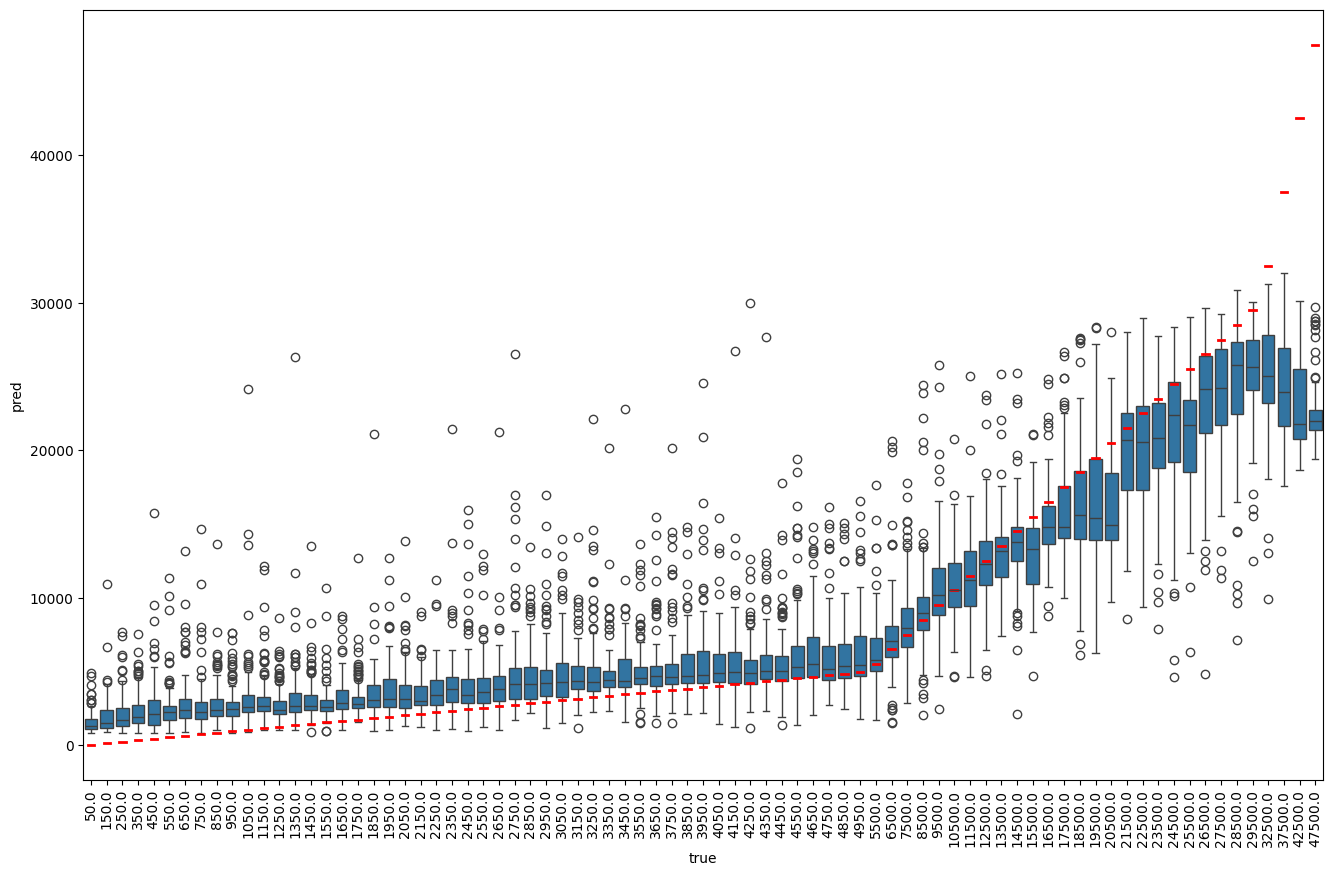

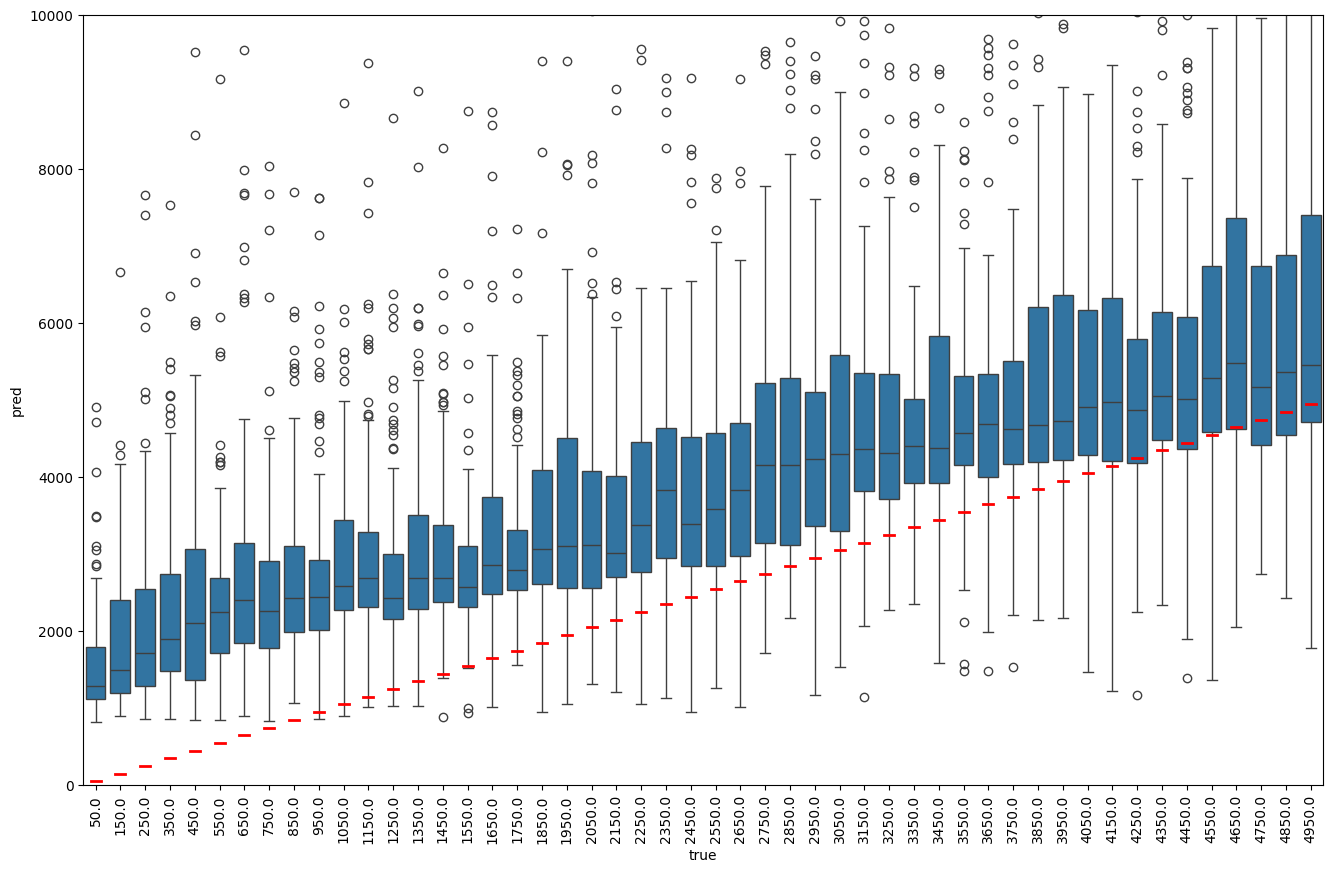

In [66]:
model = train_classic_model(
    RandomForestRegressor,
        # results.get_best_result().config,
    {'n_estimators': 150, 'max_depth': 10, 'criterion': 'poisson', 'max_features': 0.3},
        X_train_bal,
        y_train_bal,
    )
preds = prepare_classic_predictions(
    model,
    X_test_bal,
    y_test_bal,
)

boxplot_predictions(
    preds["y_pred_unique"], preds["y_true_unique"]
)
ax = boxplot_predictions_zoomed(
    preds["y_pred_unique"], preds["y_true_unique"]
)
ax.set_ylim(0, 10000)

In [ ]:
# C

## XGB

In [ ]:
tuner = tune.Tuner(
    tune.with_parameters(
        train_model_tune,
        model_cls=XGBRegressor,
        X_train=X_train_bal,
        y_train=y_train_bal,
        X_val=X_val_bal,
        y_val=y_val_bal,
    ),
    param_space={
        "n_estimators": tune.grid_search([10, 50, 100, 150]),
        "max_depth": tune.grid_search([1, 3, 5, 10, None]),
        "booster": tune.grid_search(['gbtree', 'gblinear', 'dart']),
        "subsample": tune.grid_search([0.5, 0.75, 1])
    },
    tune_config=tune.TuneConfig(
        num_samples=1,
        metric="mae",
        mode="min"
    )
)

results = tuner.fit()
best_metrics = results.get_best_result().metrics
print(f"Best params: {results.get_best_result().config}")
for k, v in best_metrics.items():
  if isinstance(v, float):
    print(f"{k}: {v:.4f}")
  else:
    print(f"{k}: {v}")

+-------------------------------------------------------------------------+
| Configuration for experiment     train_model_tune_2025-06-09_14-31-23   |
+-------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                  |
| Scheduler                        FIFOScheduler                          |
| Number of trials                 180                                    |
+-------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_tune_2025-06-09_14-31-23
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-06-09_14-03-33_810244_3164/artifacts/2025-06-09_14-31-23/train_model_tune_2025-06-09_14-31-23/driver_artifacts`

Trial status: 180 PENDING
Current time: 2025-06-09 14:31:25. Total running time: 2s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
+------------------------------------------------

(train_model_tune pid=34108) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:29] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=34108) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=34108) 
(train_model_tune pid=34108)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=34107) 
(train_model_tune pid=34145) 



Trial train_model_tune_6adc7_00001 completed after 1 iterations at 2025-06-09 14:31:29. Total running time: 6s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00001 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.43337 |
| time_total_s                                      0.43337 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00000 completed after 1 iterations at 2025-06-09 14:31:29. Total running time: 6s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_0

(train_model_tune pid=34770) Parameters: { "subsample" } are not used.
(train_model_tune pid=34770) 
(train_model_tune pid=34770) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:37] WARNING: /workspace/src/learner.cc:740:  [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_model_tune pid=34145) Parameters: { "max_depth", "subsample" } are not used. [repeated 2x across cluster]
(train_model_tune pid=34770)   warnings.warn(smsg, UserWarning) [repeated 3x across cluster]



Trial train_model_tune_6adc7_00014 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00014 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                          |
| n_estimators                                    10 |
| subsample                                      0.5 |
+----------------------------------------------------+

Trial train_model_tune_6adc7_00010 started with configuration:
+--------------------------------------------------------+
| Trial train_model_tune_6adc7_00010 config              |
+--------------------------------------------------------+
| booster                                       gblinear |
| max_depth                                           10 |
| n_estimators                                        10 |
| subsample                                          0.5 |
+------------------

(train_model_tune pid=34763) 



Trial train_model_tune_6adc7_00010 completed after 1 iterations at 2025-06-09 14:31:37. Total running time: 14s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00010 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.49982 |
| time_total_s                                      0.49982 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00012 completed after 1 iterations at 2025-06-09 14:31:38. Total running time: 15s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7

(train_model_tune pid=35284) 
(train_model_tune pid=35284) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:44] WARNING: /workspace/src/learner.cc:740:  [repeated 2x across cluster]
(train_model_tune pid=35284) Parameters: { "max_depth", "subsample" } are not used. [repeated 2x across cluster]
(train_model_tune pid=35284)   warnings.warn(smsg, UserWarning) [repeated 2x across cluster]



Trial train_model_tune_6adc7_00017 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00017 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                        1 |
| n_estimators                                    50 |
| subsample                                      0.5 |
+----------------------------------------------------+

Trial train_model_tune_6adc7_00020 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00020 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                        3 |
| n_estimators                                    50 |
| subsample                                      0.5 |
+----------------------------------------------

(train_model_tune pid=35294) 



Trial train_model_tune_6adc7_00021 started with configuration:
+------------------------------------------------------+
| Trial train_model_tune_6adc7_00021 config            |
+------------------------------------------------------+
| booster                                       gbtree |
| max_depth                                          5 |
| n_estimators                                      50 |
| subsample                                        0.5 |
+------------------------------------------------------+

Trial train_model_tune_6adc7_00019 completed after 1 iterations at 2025-06-09 14:31:47. Total running time: 23s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00019 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.50765 |
| time_total_s                                     1.50765 |
|

(train_model_tune pid=35550) 



Trial train_model_tune_6adc7_00022 completed after 1 iterations at 2025-06-09 14:31:50. Total running time: 27s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00022 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.84284 |
| time_total_s                                     1.84284 |
| training_iteration                                     1 |
| mae                                              3252.38 |
| mse                                           2.8548e+07 |
| r2                                               0.79318 |
+----------------------------------------------------------+

Trial train_model_tune_6adc7_00024 started with configuration:
+------------------------------------------------------+
| Trial train_model_tune_6adc7_00024 config            |
+-------------------------------------

(train_model_tune pid=35762) 
(train_model_tune pid=35762) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:52] WARNING: /workspace/src/learner.cc:740:  [repeated 3x across cluster]
(train_model_tune pid=35762) Parameters: { "max_depth", "subsample" } are not used. [repeated 3x across cluster]
(train_model_tune pid=35762)   warnings.warn(smsg, UserWarning) [repeated 3x across cluster]



Trial train_model_tune_6adc7_00027 completed after 1 iterations at 2025-06-09 14:31:54. Total running time: 31s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00027 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  1.70385 |
| time_total_s                                      1.70385 |
| training_iteration                                      1 |
| mae                                               3272.65 |
| mse                                           3.02715e+07 |
| r2                                                0.78069 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00025 completed after 1 iterations at 2025-06-09 14:31:54. Total running time: 31s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_

(train_model_tune pid=36027) Parameters: { "subsample" } are not used.
(train_model_tune pid=36027) 



Trial train_model_tune_6adc7_00024 completed after 1 iterations at 2025-06-09 14:31:56. Total running time: 33s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00024 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  5.31339 |
| time_total_s                                      5.31339 |
| training_iteration                                      1 |
| mae                                               3463.68 |
| mse                                           3.26064e+07 |
| r2                                                0.76378 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00028 completed after 1 iterations at 2025-06-09 14:31:57. Total running time: 34s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_

(train_model_tune pid=36274) 
(train_model_tune pid=36274) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:32:01] WARNING: /workspace/src/learner.cc:740:  [repeated 2x across cluster]
(train_model_tune pid=36274) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=36274)   warnings.warn(smsg, UserWarning) [repeated 2x across cluster]



Trial train_model_tune_6adc7_00031 completed after 1 iterations at 2025-06-09 14:32:03. Total running time: 40s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00031 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.39904 |
| time_total_s                                      2.39904 |
| training_iteration                                      1 |
| mae                                               3143.86 |
| mse                                           2.75307e+07 |
| r2                                                0.80055 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00033 started with configuration:
+------------------------------------------------------+
| Trial train_model_tune_6adc7_00033 config            |
+--------------------------

(train_model_tune pid=36567) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=36567) 
(train_model_tune pid=36567) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:32:09] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=36567)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00034 completed after 1 iterations at 2025-06-09 14:32:12. Total running time: 49s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00034 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.94381 |
| time_total_s                                      2.94381 |
| training_iteration                                      1 |
| mae                                               3143.86 |
| mse                                           2.75307e+07 |
| r2                                                0.80055 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00035 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00035 config          |
+------------------------------

(train_model_tune pid=36893) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:32:25] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=36893) 
(train_model_tune pid=36893)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=36893) Parameters: { "max_depth", "subsample" } are not used.



Trial status: 30 TERMINATED | 8 RUNNING | 142 PENDING
Current time: 2025-06-09 14:32:25. Total running time: 1min 2s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00014 with mae=3087.6242971656848 and params={'n_estimators': 10, 'max_depth': None, 'booster': 'dart', 'subsample': 0.5}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                     status         n_estimators     max_depth   booster       subsample     iter     total time (s)       mae           mse         r2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_tune_6adc7_00017   RUNNING                  50             1   dart                0.5                                                                |
| train_model_tune_6adc7_

(train_model_tune pid=37254) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=37254) 
(train_model_tune pid=37254) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:32:53] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=37254)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00041 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00041 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                       10 |
| n_estimators                                   100 |
| subsample                                      0.5 |
+----------------------------------------------------+

Trial status: 34 TERMINATED | 8 RUNNING | 138 PENDING
Current time: 2025-06-09 14:32:55. Total running time: 1min 32s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00014 with mae=3087.6242971656848 and params={'n_estimators': 10, 'max_depth': None, 'booster': 'dart', 'subsample': 0.5}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name      

(train_model_tune pid=37434) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:33:02] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=37434) Parameters: { "subsample" } are not used.
(train_model_tune pid=37434) 
(train_model_tune pid=37434)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00042 completed after 1 iterations at 2025-06-09 14:33:04. Total running time: 1min 41s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00042 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.63338 |
| time_total_s                                      2.63338 |
| training_iteration                                      1 |
| mae                                               3373.62 |
| mse                                           3.21872e+07 |
| r2                                                0.76681 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00044 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00044 config          |
+-------------------------

(train_model_tune pid=37719) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=37719) 
(train_model_tune pid=37719) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:33:09] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=37719)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00047 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00047 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                        1 |
| n_estimators                                   150 |
| subsample                                      0.5 |
+----------------------------------------------------+

Trial train_model_tune_6adc7_00048 started with configuration:
+------------------------------------------------------+
| Trial train_model_tune_6adc7_00048 config            |
+------------------------------------------------------+
| booster                                       gbtree |
| max_depth                                          3 |
| n_estimators                                     150 |
| subsample                                        0.5 |
+--------------------------------

(train_model_tune pid=37970) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:33:17] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=37970) 
(train_model_tune pid=37970)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=37970) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00050 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00050 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                        3 |
| n_estimators                                   150 |
| subsample                                      0.5 |
+----------------------------------------------------+

Trial train_model_tune_6adc7_00049 completed after 1 iterations at 2025-06-09 14:33:20. Total running time: 1min 57s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00049 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                   3.7564 |
| time_total_s                                       3.7564 |
| trai

(train_model_tune pid=38260) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=38260) 
(train_model_tune pid=38260) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:33:34] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=38260)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00052 completed after 1 iterations at 2025-06-09 14:33:37. Total running time: 2min 14s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00052 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.51096 |
| time_total_s                                      3.51096 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00053 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00053 config          |
+-------------------------

(train_model_tune pid=39193) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:19] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=39193) 
(train_model_tune pid=39193)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=39193) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00056 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00056 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                       10 |
| n_estimators                                   150 |
| subsample                                      0.5 |
+----------------------------------------------------+

Trial train_model_tune_6adc7_00055 completed after 1 iterations at 2025-06-09 14:36:23. Total running time: 5min 0s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00055 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.48226 |
| time_total_s                                      3.48226 |
| train

(train_model_tune pid=39482) Parameters: { "subsample" } are not used.
(train_model_tune pid=39482) 
(train_model_tune pid=39482) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:37] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=39482)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00058 completed after 1 iterations at 2025-06-09 14:36:41. Total running time: 5min 18s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00058 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.53576 |
| time_total_s                                      3.53576 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00059 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00059 config          |
+-------------------------

(train_model_tune pid=39793) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:52] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=39793) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=39793) 
(train_model_tune pid=39793)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00061 completed after 1 iterations at 2025-06-09 14:36:52. Total running time: 5min 29s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00061 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                   0.4386 |
| time_total_s                                       0.4386 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial status: 55 TERMINATED | 7 RUNNING | 118 PENDING
Current time: 2025-06-09 14:36:55. Total running time: 5min 32s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00014 with

(train_model_tune pid=40114) 
(train_model_tune pid=40114) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:09] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=40114) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=40114)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00064 completed after 1 iterations at 2025-06-09 14:37:09. Total running time: 5min 46s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00064 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.41157 |
| time_total_s                                      0.41157 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00065 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00065 config          |
+-------------------------

(train_model_tune pid=40347) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:14] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=40347) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=40347) 
(train_model_tune pid=40347)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00067 completed after 1 iterations at 2025-06-09 14:37:14. Total running time: 5min 51s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00067 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.38221 |
| time_total_s                                      0.38221 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00066 completed after 1 iterations at 2025-06-09 14:37:15. Total running time: 5min 51s
+----------------------------------------------------------+
| Trial train_model_t

(train_model_tune pid=40511) 
(train_model_tune pid=40511) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:21] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=40511) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=40511)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00070 completed after 1 iterations at 2025-06-09 14:37:21. Total running time: 5min 58s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00070 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.54309 |
| time_total_s                                      0.54309 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00068 completed after 1 iterations at 2025-06-09 14:37:22. Total running time: 5min 59s
+-----------------------------------------------------------+
| Trial train_model_

(train_model_tune pid=40760) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:28] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=40760) Parameters: { "subsample" } are not used.
(train_model_tune pid=40760) 
(train_model_tune pid=40760)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00073 completed after 1 iterations at 2025-06-09 14:37:28. Total running time: 6min 5s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00073 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.39691 |
| time_total_s                                      0.39691 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00072 completed after 1 iterations at 2025-06-09 14:37:28. Total running time: 6min 5s
+-----------------------------------------------------------+
| Trial train_model_tu

(train_model_tune pid=41045) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=41045) 
(train_model_tune pid=41045) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:34] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=41045)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00076 completed after 1 iterations at 2025-06-09 14:37:35. Total running time: 6min 12s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00076 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.24373 |
| time_total_s                                     1.24373 |
| training_iteration                                     1 |
| mae                                              3252.38 |
| mse                                           2.8548e+07 |
| r2                                               0.79318 |
+----------------------------------------------------------+

Trial train_model_tune_6adc7_00074 completed after 1 iterations at 2025-06-09 14:37:36. Total running time: 6min 13s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_

(train_model_tune pid=41244) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:40] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=41244) 
(train_model_tune pid=41244)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=41244) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00078 completed after 1 iterations at 2025-06-09 14:37:41. Total running time: 6min 18s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00078 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.81874 |
| time_total_s                                      0.81874 |
| training_iteration                                      1 |
| mae                                               3074.88 |
| mse                                           2.70897e+07 |
| r2                                                0.80374 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00079 completed after 1 iterations at 2025-06-09 14:37:42. Total running time: 6min 19s
+----------------------------------------------------------+
| Trial train_model_t

(train_model_tune pid=41670) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=41670) 
(train_model_tune pid=41670) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:53] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=41670)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00082 completed after 1 iterations at 2025-06-09 14:37:54. Total running time: 6min 31s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00082 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.24651 |
| time_total_s                                     1.24651 |
| training_iteration                                     1 |
| mae                                              3252.38 |
| mse                                           2.8548e+07 |
| r2                                               0.79318 |
+----------------------------------------------------------+

Trial status: 76 TERMINATED | 7 RUNNING | 97 PENDING
Current time: 2025-06-09 14:37:55. Total running time: 6min 32s
Logical resource usage: 7.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00068 with mae=3072.35

(train_model_tune pid=42176) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:38:54] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=42176) 
(train_model_tune pid=42176)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=42176) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00086 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00086 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                       10 |
| n_estimators                                    50 |
| subsample                                     0.75 |
+----------------------------------------------------+

Trial train_model_tune_6adc7_00085 completed after 1 iterations at 2025-06-09 14:38:55. Total running time: 7min 32s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00085 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.40178 |
| time_total_s                                     1.40178 |
| training_i

(train_model_tune pid=42487) Parameters: { "subsample" } are not used.
(train_model_tune pid=42487) 
(train_model_tune pid=42487) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:39:07] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=42487)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00088 completed after 1 iterations at 2025-06-09 14:39:09. Total running time: 7min 45s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00088 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.48873 |
| time_total_s                                     1.48873 |
| training_iteration                                     1 |
| mae                                              3252.38 |
| mse                                           2.8548e+07 |
| r2                                               0.79318 |
+----------------------------------------------------------+

Trial train_model_tune_6adc7_00090 started with configuration:
+------------------------------------------------------+
| Trial train_model_tune_6adc7_00090 config            |
+--------------------------------

(train_model_tune pid=42757) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:39:20] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=42757) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=42757) 
(train_model_tune pid=42757)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00091 completed after 1 iterations at 2025-06-09 14:39:23. Total running time: 7min 59s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00091 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.40926 |
| time_total_s                                      2.40926 |
| training_iteration                                      1 |
| mae                                               3143.86 |
| mse                                           2.75307e+07 |
| r2                                                0.80055 |
+-----------------------------------------------------------+

Trial status: 85 TERMINATED | 7 RUNNING | 88 PENDING
Current time: 2025-06-09 14:39:26. Total running time: 8min 2s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00068 with m

(train_model_tune pid=43226) 
(train_model_tune pid=43226) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:40:12] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=43226) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=43226)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00095 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00095 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                        3 |
| n_estimators                                   100 |
| subsample                                     0.75 |
+----------------------------------------------------+

Trial train_model_tune_6adc7_00094 completed after 1 iterations at 2025-06-09 14:40:14. Total running time: 8min 51s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00094 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.30879 |
| time_total_s                                      2.30879 |
| trai

(train_model_tune pid=43508) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:40:27] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=43508) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=43508) 
(train_model_tune pid=43508)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00097 completed after 1 iterations at 2025-06-09 14:40:30. Total running time: 9min 6s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00097 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                   2.5027 |
| time_total_s                                       2.5027 |
| training_iteration                                      1 |
| mae                                               3143.86 |
| mse                                           2.75307e+07 |
| r2                                                0.80055 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00098 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00098 config          |
+--------------------------

(train_model_tune pid=44239) 
(train_model_tune pid=44239) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:42:23] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=44239) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=44239)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00100 completed after 1 iterations at 2025-06-09 14:42:25. Total running time: 11min 2s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00100 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.53189 |
| time_total_s                                      2.53189 |
| training_iteration                                      1 |
| mae                                               3143.86 |
| mse                                           2.75307e+07 |
| r2                                                0.80055 |
+-----------------------------------------------------------+

Trial status: 94 TERMINATED | 7 RUNNING | 79 PENDING
Current time: 2025-06-09 14:42:26. Total running time: 11min 3s
Logical resource usage: 7.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00068 with 

(train_model_tune pid=44530) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:42:40] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=44530) Parameters: { "subsample" } are not used.
(train_model_tune pid=44530) 
(train_model_tune pid=44530)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00053 completed after 1 iterations at 2025-06-09 14:42:42. Total running time: 11min 19s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00053 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  538.864 |
| time_total_s                                      538.864 |
| training_iteration                                      1 |
| mae                                               3327.47 |
| mse                                           3.18092e+07 |
| r2                                                0.76955 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00103 completed after 1 iterations at 2025-06-09 14:42:42. Total running time: 11min 19s
+-----------------------------------------------------------+
| Trial train_mode

(train_model_tune pid=44842) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=44842) 
(train_model_tune pid=44842) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:42:54] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=44842)   warnings.warn(smsg, UserWarning)



Trial status: 99 TERMINATED | 8 RUNNING | 73 PENDING
Current time: 2025-06-09 14:42:56. Total running time: 11min 33s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00068 with mae=3072.358710923658 and params={'n_estimators': 10, 'max_depth': 5, 'booster': 'dart', 'subsample': 0.75}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                     status         n_estimators     max_depth   booster       subsample     iter     total time (s)       mae           mse         r2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_tune_6adc7_00056   RUNNING                 150            10   dart               0.5                                                                 |
| train_model_tune_6adc7_00

(train_model_tune pid=45273) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:43:36] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=45273) 
(train_model_tune pid=45273)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=45273) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00109 completed after 1 iterations at 2025-06-09 14:43:40. Total running time: 12min 17s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00109 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.44927 |
| time_total_s                                      3.44927 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00110 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00110 config          |
+------------------------

(train_model_tune pid=45733) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=45733) 
(train_model_tune pid=45733) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:44:27] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=45733)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00112 completed after 1 iterations at 2025-06-09 14:44:30. Total running time: 13min 7s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00112 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.57834 |
| time_total_s                                      3.57834 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00113 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00113 config          |
+-------------------------

(train_model_tune pid=46206) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:45:20] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=46206) 
(train_model_tune pid=46206)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=46206) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00115 completed after 1 iterations at 2025-06-09 14:45:23. Total running time: 14min 0s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00115 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.47095 |
| time_total_s                                      3.47095 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial status: 109 TERMINATED | 7 RUNNING | 64 PENDING
Current time: 2025-06-09 14:45:26. Total running time: 14min 3s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00068 with

(train_model_tune pid=46595) Parameters: { "subsample" } are not used.
(train_model_tune pid=46595) 
(train_model_tune pid=46595) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:45:52] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=46595)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00118 completed after 1 iterations at 2025-06-09 14:45:56. Total running time: 14min 32s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00118 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                   4.0907 |
| time_total_s                                       4.0907 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial status: 112 TERMINATED | 7 RUNNING | 61 PENDING
Current time: 2025-06-09 14:45:56. Total running time: 14min 33s
Logical resource usage: 7.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00068 wi

(train_model_tune pid=47022) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:34] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=47022) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=47022) 
(train_model_tune pid=47022)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00121 completed after 1 iterations at 2025-06-09 14:46:35. Total running time: 15min 12s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00121 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.38516 |
| time_total_s                                      0.38516 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00122 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00122 config          |
+------------------------

(train_model_tune pid=47290) 
(train_model_tune pid=47290) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:49] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=47290) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=47290)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00124 completed after 1 iterations at 2025-06-09 14:46:49. Total running time: 15min 26s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00124 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                   0.3879 |
| time_total_s                                       0.3879 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00123 completed after 1 iterations at 2025-06-09 14:46:49. Total running time: 15min 26s
+-----------------------------------------------------------+
| Trial train_mode

(train_model_tune pid=47446) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:54] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=47446) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=47446) 
(train_model_tune pid=47446)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00127 completed after 1 iterations at 2025-06-09 14:46:54. Total running time: 15min 31s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00127 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.38723 |
| time_total_s                                      0.38723 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00126 completed after 1 iterations at 2025-06-09 14:46:54. Total running time: 15min 31s
+----------------------------------------------------------+
| Trial train_model

(train_model_tune pid=47731) 
(train_model_tune pid=47731) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:47:01] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=47731) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=47731)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00130 completed after 1 iterations at 2025-06-09 14:47:01. Total running time: 15min 38s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00130 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.56211 |
| time_total_s                                      0.56211 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00129 completed after 1 iterations at 2025-06-09 14:47:02. Total running time: 15min 39s
+-----------------------------------------------------------+
| Trial train_mode

(train_model_tune pid=47935) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:47:08] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=47935) Parameters: { "subsample" } are not used.
(train_model_tune pid=47935) 
(train_model_tune pid=47935)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00133 completed after 1 iterations at 2025-06-09 14:47:08. Total running time: 15min 45s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00133 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.42129 |
| time_total_s                                      0.42129 |
| training_iteration                                      1 |
| mae                                               3815.66 |
| mse                                           3.48715e+07 |
| r2                                                0.74737 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00132 completed after 1 iterations at 2025-06-09 14:47:08. Total running time: 15min 45s
+-----------------------------------------------------------+
| Trial train_mode

(train_model_tune pid=48220) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=48220) 
(train_model_tune pid=48220) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:47:15] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=48220)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00136 completed after 1 iterations at 2025-06-09 14:47:16. Total running time: 15min 53s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00136 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.52778 |
| time_total_s                                     1.52778 |
| training_iteration                                     1 |
| mae                                              3252.38 |
| mse                                           2.8548e+07 |
| r2                                               0.79318 |
+----------------------------------------------------------+

Trial train_model_tune_6adc7_00134 completed after 1 iterations at 2025-06-09 14:47:17. Total running time: 15min 54s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc

(train_model_tune pid=48420) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:47:21] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=48420) 
(train_model_tune pid=48420)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=48420) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00138 completed after 1 iterations at 2025-06-09 14:47:21. Total running time: 15min 58s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00138 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  0.81938 |
| time_total_s                                      0.81938 |
| training_iteration                                      1 |
| mae                                               3058.38 |
| mse                                           2.68846e+07 |
| r2                                                0.80523 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00139 completed after 1 iterations at 2025-06-09 14:47:22. Total running time: 15min 59s
+----------------------------------------------------------+
| Trial train_model

(train_model_tune pid=48809) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=48809) 
(train_model_tune pid=48809) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:47:34] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=48809)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00142 completed after 1 iterations at 2025-06-09 14:47:35. Total running time: 16min 12s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00142 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.46625 |
| time_total_s                                     1.46625 |
| training_iteration                                     1 |
| mae                                              3252.38 |
| mse                                           2.8548e+07 |
| r2                                               0.79318 |
+----------------------------------------------------------+

Trial train_model_tune_6adc7_00143 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00143 config          |
+-----------------------------------

(train_model_tune pid=49351) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:35] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=49351) 
(train_model_tune pid=49351)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=49351) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00145 completed after 1 iterations at 2025-06-09 14:48:36. Total running time: 17min 13s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00145 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.25253 |
| time_total_s                                     1.25253 |
| training_iteration                                     1 |
| mae                                              3252.38 |
| mse                                           2.8548e+07 |
| r2                                               0.79318 |
+----------------------------------------------------------+

Trial train_model_tune_6adc7_00147 started with configuration:
+------------------------------------------------------+
| Trial train_model_tune_6adc7_00147 config            |
+-------------------------------

(train_model_tune pid=49627) Parameters: { "subsample" } are not used.
(train_model_tune pid=49627) 
(train_model_tune pid=49627) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:49] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=49627)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00149 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00149 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                          |
| n_estimators                                    50 |
| subsample                                        1 |
+----------------------------------------------------+

Trial train_model_tune_6adc7_00148 completed after 1 iterations at 2025-06-09 14:48:50. Total running time: 17min 27s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00148 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 1.48236 |
| time_total_s                                     1.48236 |
| training_

(train_model_tune pid=49895) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:49:02] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=49895) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=49895) 
(train_model_tune pid=49895)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00151 completed after 1 iterations at 2025-06-09 14:49:04. Total running time: 17min 41s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00151 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.56596 |
| time_total_s                                      2.56596 |
| training_iteration                                      1 |
| mae                                               3143.86 |
| mse                                           2.75307e+07 |
| r2                                                0.80055 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00152 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00152 config          |
+------------------------

(train_model_tune pid=50366) 
(train_model_tune pid=50366) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:49:55] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=50366) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=50366)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00155 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00155 config          |
+----------------------------------------------------+
| booster                                       dart |
| max_depth                                        3 |
| n_estimators                                   100 |
| subsample                                        1 |
+----------------------------------------------------+

Trial status: 148 TERMINATED | 8 RUNNING | 24 PENDING
Current time: 2025-06-09 14:49:57. Total running time: 18min 34s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00140 with mae=3058.3776618422216 and params={'n_estimators': 50, 'max_depth': 3, 'booster': 'dart', 'subsample': 1}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name          

(train_model_tune pid=50649) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:50:11] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=50649) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=50649) 
(train_model_tune pid=50649)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00157 completed after 1 iterations at 2025-06-09 14:50:13. Total running time: 18min 50s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00157 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.48647 |
| time_total_s                                      2.48647 |
| training_iteration                                      1 |
| mae                                               3143.86 |
| mse                                           2.75307e+07 |
| r2                                                0.80055 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00158 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00158 config          |
+------------------------

(train_model_tune pid=51457) 
(train_model_tune pid=51457) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:26] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=51457) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=51457)   warnings.warn(smsg, UserWarning)



Trial status: 153 TERMINATED | 8 RUNNING | 19 PENDING
Current time: 2025-06-09 14:52:27. Total running time: 21min 4s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00140 with mae=3058.3776618422216 and params={'n_estimators': 50, 'max_depth': 3, 'booster': 'dart', 'subsample': 1}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                     status         n_estimators     max_depth   booster       subsample     iter     total time (s)       mae           mse         r2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_tune_6adc7_00110   RUNNING                 150             3   dart               0.75                                                                |
| train_model_tune_6adc7_0011

(train_model_tune pid=51777) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:41] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=51777) Parameters: { "subsample" } are not used.
(train_model_tune pid=51777) 
(train_model_tune pid=51777)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00163 completed after 1 iterations at 2025-06-09 14:52:43. Total running time: 21min 20s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00163 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  2.37646 |
| time_total_s                                      2.37646 |
| training_iteration                                      1 |
| mae                                               3143.86 |
| mse                                           2.75307e+07 |
| r2                                                0.80055 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00164 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00164 config          |
+------------------------

(train_model_tune pid=52186) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=52186) 
(train_model_tune pid=52186) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:53:19] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=52186)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00166 completed after 1 iterations at 2025-06-09 14:53:22. Total running time: 21min 59s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00166 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.41029 |
| time_total_s                                      3.41029 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial status: 160 TERMINATED | 7 RUNNING | 13 PENDING
Current time: 2025-06-09 14:53:27. Total running time: 22min 4s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00140 wit

(train_model_tune pid=52600) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:53:57] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=52600) 
(train_model_tune pid=52600)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=52600) Parameters: { "max_depth", "subsample" } are not used.



Trial status: 163 TERMINATED | 7 RUNNING | 10 PENDING
Current time: 2025-06-09 14:53:57. Total running time: 22min 34s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00140 with mae=3058.3776618422216 and params={'n_estimators': 50, 'max_depth': 3, 'booster': 'dart', 'subsample': 1}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                     status         n_estimators     max_depth   booster       subsample     iter     total time (s)       mae           mse         r2 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_tune_6adc7_00116   RUNNING                 150            10   dart               0.75                                                                |
| train_model_tune_6adc7_001

(train_model_tune pid=52926) Parameters: { "max_depth", "subsample" } are not used.
(train_model_tune pid=52926) 
(train_model_tune pid=52926) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:54:14] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=52926)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00172 completed after 1 iterations at 2025-06-09 14:54:17. Total running time: 22min 54s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00172 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.52638 |
| time_total_s                                      3.52638 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00173 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00173 config          |
+------------------------

(train_model_tune pid=53305) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:54:43] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=53305) 
(train_model_tune pid=53305)   warnings.warn(smsg, UserWarning)
(train_model_tune pid=53305) Parameters: { "max_depth", "subsample" } are not used.



Trial train_model_tune_6adc7_00175 completed after 1 iterations at 2025-06-09 14:54:46. Total running time: 23min 23s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00175 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  3.51451 |
| time_total_s                                      3.51451 |
| training_iteration                                      1 |
| mae                                               3113.96 |
| mse                                           2.72804e+07 |
| r2                                                0.80236 |
+-----------------------------------------------------------+

Trial train_model_tune_6adc7_00176 started with configuration:
+----------------------------------------------------+
| Trial train_model_tune_6adc7_00176 config          |
+------------------------

(train_model_tune pid=53568) Parameters: { "subsample" } are not used.
(train_model_tune pid=53568) 
(train_model_tune pid=53568) /usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:55:05] WARNING: /workspace/src/learner.cc:740: 
(train_model_tune pid=53568)   warnings.warn(smsg, UserWarning)



Trial train_model_tune_6adc7_00177 completed after 1 iterations at 2025-06-09 14:55:07. Total running time: 23min 44s
+----------------------------------------------------------+
| Trial train_model_tune_6adc7_00177 result                |
+----------------------------------------------------------+
| checkpoint_dir_name                                      |
| time_this_iter_s                                 3.50145 |
| time_total_s                                     3.50145 |
| training_iteration                                     1 |
| mae                                              3178.05 |
| mse                                           2.8302e+07 |
| r2                                               0.79496 |
+----------------------------------------------------------+

Trial train_model_tune_6adc7_00178 completed after 1 iterations at 2025-06-09 14:55:08. Total running time: 23min 45s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc

2025-06-09 15:01:43,088	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_tune_2025-06-09_14-31-23' in 0.0457s.



Trial train_model_tune_6adc7_00176 completed after 1 iterations at 2025-06-09 15:01:43. Total running time: 30min 19s
+-----------------------------------------------------------+
| Trial train_model_tune_6adc7_00176 result                 |
+-----------------------------------------------------------+
| checkpoint_dir_name                                       |
| time_this_iter_s                                  411.103 |
| time_total_s                                      411.103 |
| training_iteration                                      1 |
| mae                                               3278.58 |
| mse                                           2.98077e+07 |
| r2                                                0.78405 |
+-----------------------------------------------------------+

Trial status: 180 TERMINATED
Current time: 2025-06-09 15:01:43. Total running time: 30min 19s
Logical resource usage: 1.0/8 CPUs, 0/0 GPUs
Current best trial: 6adc7_00140 with mae=3058.3776618422216

In [67]:
run_classic_model(
    XGBRegressor,
    # results.get_best_result().config,
    {'n_estimators': 50, 'max_depth': 3, 'booster': 'dart', 'subsample': 1},
    X_train=X_train_bal,
    y_train=y_train_bal,
    # X_val=X_val_bal,
    # y_val=y_val_bal,
    X_test=X_test_bal,
    y_test=y_test_bal,
)

[3.9044079780578613, 4.160780668258667, 3.920635461807251, 3.8026270866394043, 4.220934629440308]
4.0019 ± 0.1606
Range & MAE & RMSE & R2 \\
0-500 & 1323.1678 ± 0.0000 & 4489904.7470 ± 0.0000 \\
500-1000 & 1489.3533 ± 0.0000 & 5976412.7941 ± 0.0000 \\
1000-2000 & 1360.0554 ± 0.0000 & 6324645.8471 ± 0.0000 \\
2000-5000 & 1759.3395 ± 0.0000 & 9437182.4622 ± 0.0000 \\
5000-10000 & 2363.5612 ± 0.0000 & 13666004.5169 ± 0.0000 \\
10000-47500 & 3691.2949 ± 0.0000 & 25036258.6617 ± 0.0000 \\



In [68]:
run_classic_model(
    XGBRegressor,
    # results.get_best_result().config,
    {'n_estimators': 50, 'max_depth': 3, 'booster': 'dart', 'subsample': 1},
    X_train=X_train_bal,
    y_train=y_train_bal,
    # X_val=X_val_bal,
    # y_val=y_val_bal,
    X_test=X_val_bal,
    y_test=y_val_bal,
)

[3.8292479515075684, 3.9275548458099365, 4.278458833694458, 3.9350080490112305, 3.8789501190185547]
3.9698 ± 0.1589
Range & MAE & RMSE & R2 \\
0-500 & 1737.1351 ± 0.0000 & 9071460.2376 ± 0.0000 \\
500-1000 & 2574.1160 ± 0.0000 & 18845409.9143 ± 0.0000 \\
1000-2000 & 2491.5868 ± 0.0000 & 24010989.0226 ± 0.0000 \\
2000-5000 & 2734.5039 ± 0.0000 & 20671815.5092 ± 0.0000 \\
5000-10000 & 3028.9574 ± 0.0000 & 21995585.3911 ± 0.0000 \\
10000-42500 & 3315.4036 ± 0.0000 & 19878246.6999 ± 0.0000 \\



(0.0, 10000.0)

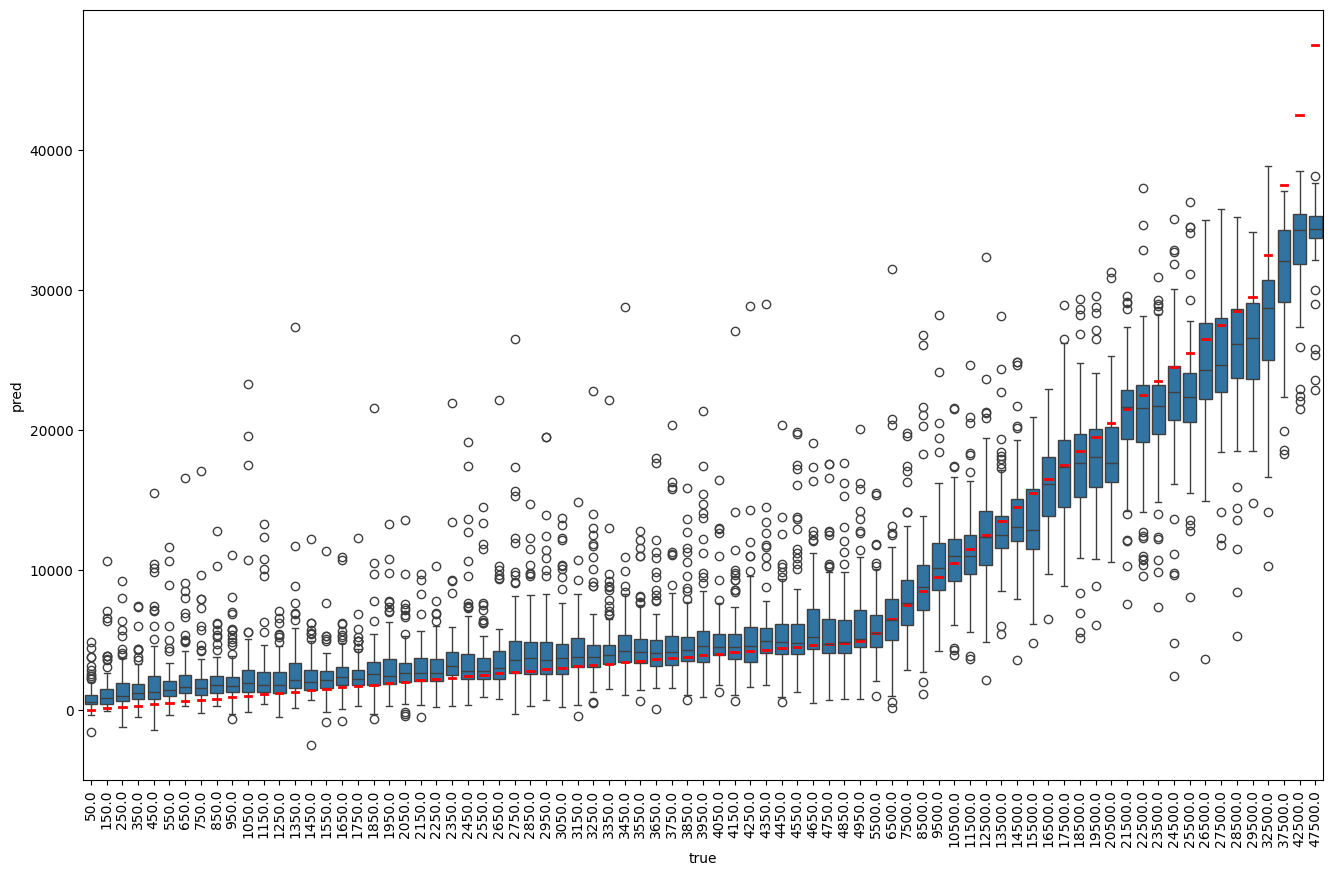

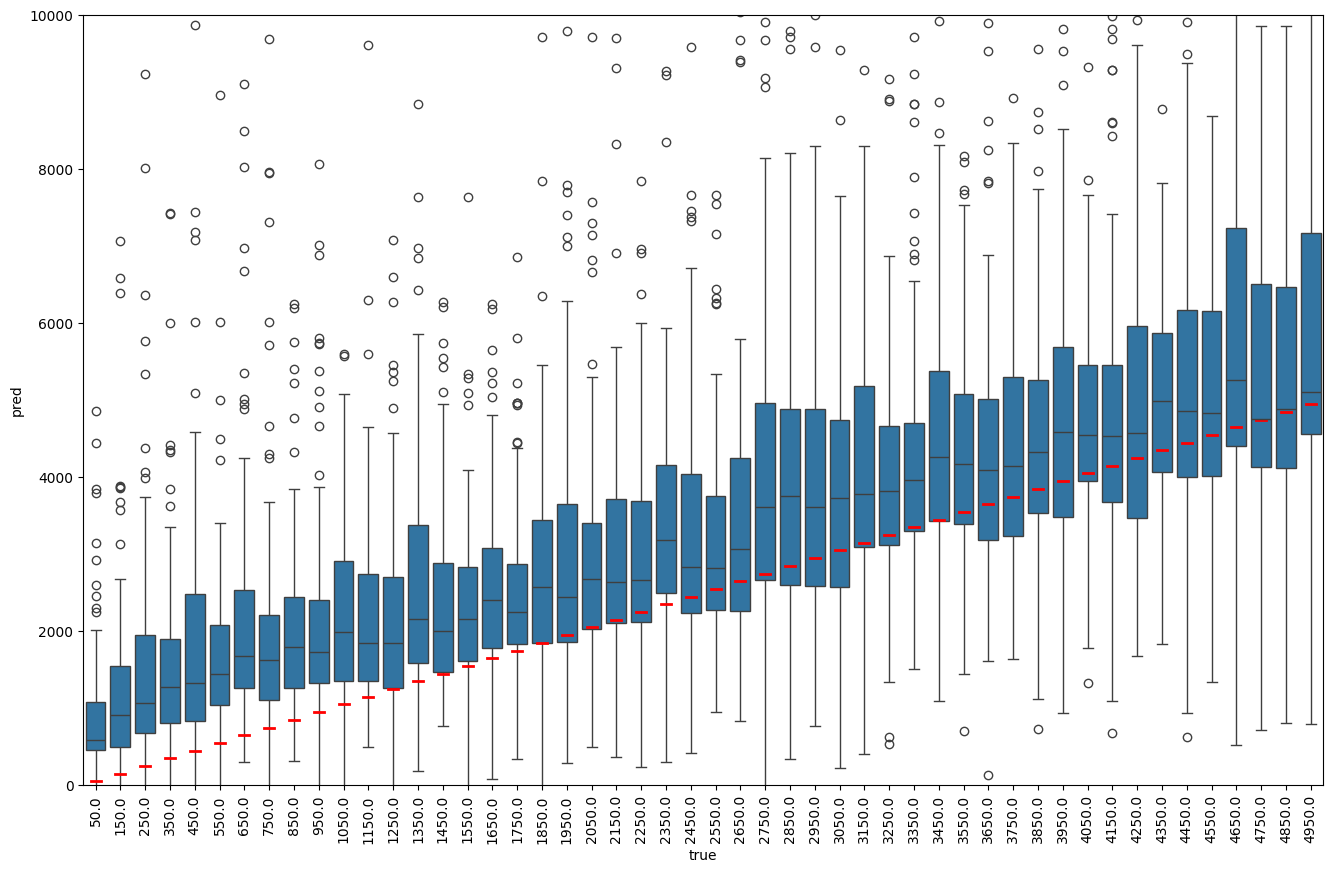

In [69]:
preds = prepare_classic_predictions(
    train_classic_model(
    XGBRegressor,
        # results.get_best_result().config,
    {'n_estimators': 50, 'max_depth': 3, 'booster': 'dart', 'subsample': 1},
        X_train_bal,
        y_train_bal,
    ),
    X_test_bal,
    y_test_bal,
)

boxplot_predictions(
    preds["y_pred_unique"], preds["y_true_unique"]
)
ax = boxplot_predictions_zoomed(
    preds["y_pred_unique"], preds["y_true_unique"]
)
ax.set_ylim(0, 10000)

## Naiva Bayes

In [ ]:
# tuner = tune.Tuner(
#     tune.with_parameters(
#         train_model_tune,
#         model_cls=GaussianNB,
#         X_train=X_train_bal,
#         y_train=y_train_bal,
#         X_val=X_val_bal,
#         y_val=y_val_bal,
#     ),
#     param_space={
#         "n_estimators": tune.grid_search([10, 50, 75, 100, 150, 200]),
#         "max_depth": tune.grid_search([1, 3, 5, 10, None]),
#         "booster": tune.grid_search(['gbtree', 'gblinear', 'dart'])
#     },
#     tune_config=tune.TuneConfig(
#         num_samples=3,
#         metric="accuracy",
#         mode="max"
#     )
# )

# results = tuner.fit()
# best_metrics = results.get_best_result().metrics
# print(f"Best params: {results.get_best_result().config}")
# for k, v in best_metrics.items():
#   if isinstance(v, float):
#     print(f"{k}: {v:.4f}")
#   else:
#     print(f"{k}: {v}")

In [ ]:
run_classic_model(
    GaussianNB,
    # results.get_best_result().config,
    {},
    X_train=X_train_bal,
    y_train=y_train_bal,
    X_val=X_val_bal,
    y_val=y_val_bal,
    X_test=X_test_bal,
    y_test=y_test_bal,
)

<class 'sklearn.naive_bayes.GaussianNB'> & 0.4478 ± 0.0000 & 0.3575 ± 0.0000 & 0.3563 ± 0.0000 & 0.3757 ± 0.0000 \\
[0.009872674942016602, 0.007849454879760742, 0.007587432861328125, 0.007434368133544922, 0.007409334182739258]
0.0080 ± 0.0009
